# Аналитика HH.ru 

**Цель проекта:** Выявить различия в предлагаемых вакансиях для Аналитиков данных и Системных аналитиков.

**Исходные данные:** Данные получены из API HH.ru



**Этапы работы:**

1. Предобработка данных.
   
2. Исследовательский анализ данных.
   
3. Выявление грейда требуемых специалистов по названию вакансии или по колонке с требуемым опытом.
   
4. Определение доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Системный аналитик.
   
5. Определение типичного места работы для Аналитика данных и Системного аналитика по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
    
6. Определение,  какие навыки спрашивают чаще - твердые или мягкие. К какому грейду и к какой специальности требований больше.
    
7. Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Системный аналитик по следующим параметрам: самые важные hard-skils, самые важные soft-skils. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
    
8. Формулирование выводов и рекомендаций.

### Загрузка модулей и данных

In [1]:
import pandas as pd
import pandas as pd
import requests
import urllib
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from numpy import median

#подгружаем первый датасет с Яндекс.диска
folder_url = 'https://disk.yandex.ru/d/1mQ8zFRPJYFZxQ'
file_url = 'vacancies_da.xlsx'
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)

r = requests.get(url)
h = json.loads(r.text)['href'] 

vac_da = pd.read_excel(h, sheet_name = 'Sheet1')

#подгружаем второй датасет с Яндекс.диска
folder_url = 'https://disk.yandex.ru/d/1mQ8zFRPJYFZxQ'
file_url = 'vacancies_sa.xlsx'
url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download' + '?public_key=' + urllib.parse.quote(folder_url) + '&path=/' + urllib.parse.quote(file_url)

r = requests.get(url) 
h = json.loads(r.text)['href'] 

vac_sa = pd.read_excel(h, sheet_name = 'Sheet1')


#vac_da = pd.read_excel ('C://Users//user//Desktop//DATA_STUDY//Workshop//vacancies_da.xlsx', sheet_name = 'Sheet1')
#vac_sa = pd.read_excel ('C://Users//user//Desktop//DATA_STUDY//Workshop//vacancies_sa.xlsx', sheet_name = 'Sheet1')

#Задаем общие настройки отображения
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
colors = sns.color_palette('deep')
sns.set_theme(style="whitegrid")

Поскольку 2 датасета обладают идентичной струткрой и различаются только по 1 внешнему признаку, типу вакансии, включим признак в датасет: для вакансий дата аналитика добавим столбец 'source' со значением data, для системного аналитика столбец 'source' будет принимать значение system.

In [2]:
vac_da['source'] = 'Аналитик данных'
vac_da.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801 entries, 0 to 1800
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1801 non-null   int64         
 1   name                              1801 non-null   object        
 2   published_at                      1801 non-null   datetime64[ns]
 3   alternate_url                     1801 non-null   object        
 4   type                              1801 non-null   object        
 5   employer                          1801 non-null   object        
 6   department                        521 non-null    object        
 7   area                              1801 non-null   object        
 8   experience                        1801 non-null   object        
 9   key_skills                        1801 non-null   object        
 10  schedule                          1801 non-null 

In [3]:
vac_sa['source'] = 'Системный аналитик'
vac_sa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915 entries, 0 to 1914
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                1915 non-null   int64         
 1   name                              1915 non-null   object        
 2   published_at                      1915 non-null   datetime64[ns]
 3   alternate_url                     1915 non-null   object        
 4   type                              1915 non-null   object        
 5   employer                          1915 non-null   object        
 6   department                        361 non-null    object        
 7   area                              1915 non-null   object        
 8   experience                        1915 non-null   object        
 9   key_skills                        1915 non-null   object        
 10  schedule                          1915 non-null 

Объединим 2 датасета в 1: это позволит не дублировать идентичные операции по предобработке данных, работать со всеми данными в рамках одного датасета, проще делать сводные таблицы для сравнения 2 типов вакансий и проще реализовывать сравнительные графики.

In [4]:
data = pd.concat([vac_sa,vac_da])

### Проверка данных

Проверим корректность данных до удаления дубликатов вакансий, т.к. скрытые дубликаты в значениях могут помешать достоверной оценке продублированных вакансий

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3716 entries, 0 to 1800
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3716 non-null   int64         
 1   name                              3716 non-null   object        
 2   published_at                      3716 non-null   datetime64[ns]
 3   alternate_url                     3716 non-null   object        
 4   type                              3716 non-null   object        
 5   employer                          3716 non-null   object        
 6   department                        882 non-null    object        
 7   area                              3716 non-null   object        
 8   experience                        3716 non-null   object        
 9   key_skills                        3716 non-null   object        
 10  schedule                          3716 non-null   obj

#### Оценка корректности численных данных

In [6]:
data[['salary_from','salary_to']].describe()

,salary_from,salary_to
count,704.00,507.00
mean,132074.70,192250.14
std,72442.60,106554.77
min,50.00,20000.00
25%,75000.00,100000.00
50%,120000.00,180000.00
75%,181750.00,280000.00
max,398000.00,580000.00


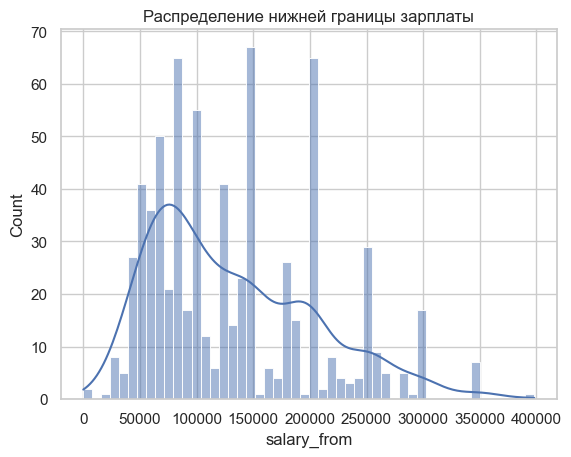

In [7]:
sns.histplot(data['salary_from'], bins=50, kde=True)
plt.title('Распределение нижней границы зарплаты');

Есть несколько аномально низких и аномально высоких значений нижней границы ЗП, проверим эти данные

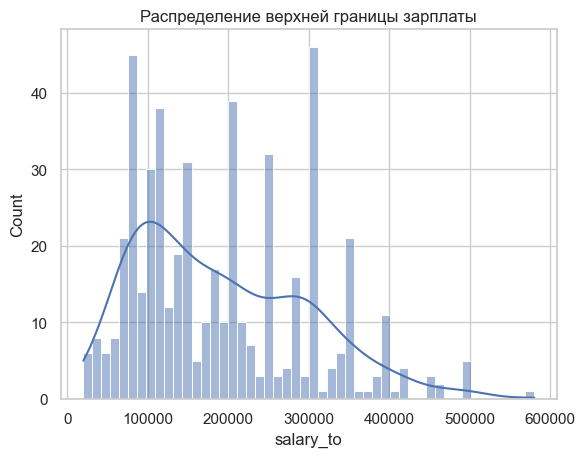

In [8]:
sns.histplot(data['salary_to'], bins=50, kde=True)
plt.title('Распределение верхней границы зарплаты');

Аномально низких значений верхней границы ЗП нет

In [9]:
data[data['salary_from']<25000]

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
871,103145776,Проект менеджер / Системный аналитик,2024-07-02 15:33:49,https://hh.ru/vacancy/103145776,Открытая,Крылов Николай Алексеевич,NaN,Москва,Junior (no experince),"['Trello', 'Подготовка презентаций', 'Планиров...",Удаленная работа,Частичная занятость,приветствую! нашей компании для создания своег...,приветствовать наш компания создание свой музы...,20000.00,20000.00,Меньше 100 тысяч,"Atlassian Jira, Trello, Atlassian Confluence, ...",confluence,NaN,Системный аналитик
1470,91944373,Системный Аналитик Middle/Senior,2024-07-06 15:14:38,https://hh.ru/vacancy/91944373,Открытая,Datanomica,NaN,Москва,Senior (6+ years),"['JSON API', 'JSON', 'XML', 'SQL', 'Юнит-эконо...",Удаленная работа,Полная занятость,"привет! мы — ооо «датаномика», решаем проблемы...",привет датаномика решать проблема структуриров...,280.00,340000.00,Больше 300 тысяч,"JSON API, XML, JSON, Agile, Java, SQL, Kafka","confluence, Юнит-экономика",NaN,Системный аналитик
1110,96943446,Аналитик данных в отдел развития на маркетплейсах,2024-05-11 21:45:07,https://hh.ru/vacancy/96943446,Открытая,Репетуев Иван Дмитриевич,NaN,Москва,Junior (no experince),"['Аналитическое мышление', 'Аналитика продаж',...",Удаленная работа,Полная занятость,ищу в команду аналитика до глубины мозга косте...,искать команда аналитик глубина мозг кость име...,50.00,100001.00,От 100 тысяч до 200 тысяч,"Аналитика продаж, Конкурентная аналитика, Анал...",NaN,NaN,Аналитик данных


Вакансия 871 предусматривает частичную занятость, зарплата в 20 000 возможна.
Зарплатная вилка от 280 до 340 000 и от 50 до 100 000 маловероятно, скорее всего в нижней границе потеряна разрядность, точечно восстановим данные:

In [10]:
data['salary_from'] = data['salary_from'].replace(50, 50000)
data['salary_from'] = data['salary_from'].replace(280, 280000)

In [11]:
data[data['salary_from']>320000]

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
735,103043223,Системный аналитик,2024-07-01 12:44:46,https://hh.ru/vacancy/103043223,Открытая,Demis Group,NaN,Москва,Middle (3-6 years),"['SQL', 'Анализ данных', 'Документация', 'conf...",Удаленная работа,Полная занятость,вакансия партнеров! альфа-банк ищет системног...,вакансия партнер альфа банк искать системный а...,350000.00,NaN,ЗП не указана,"SQL, Анализ данных, Базы данных",confluence,Документация,Системный аналитик
803,103084243,Системный аналитик (в продуктовую ИТ-компанию),2024-07-01 22:13:15,https://hh.ru/vacancy/103084243,Открытая,Vital Partners,NaN,Санкт-Петербург,Senior (6+ years),"['REST', 'SQL', 'Анализ данных', 'SOAP', 'UML'...",Удаленная работа,Полная занятость,наш клиент: продуктовая it аккредитованная ком...,наш клиент продуктовый it аккредитовать компан...,350000.00,420000.00,Больше 300 тысяч,"REST, SQL, UML, Анализ данных, Camunda, Kafka,...",NaN,NaN,Системный аналитик
960,103227680,Системный аналитик (ДБО),2024-07-03 15:23:12,https://hh.ru/vacancy/103227680,Открытая,АйТиКвик,NaN,Санкт-Петербург,Senior (6+ years),"['Scrum', 'REST', 'Atlassian Jira', 'SQL', 'XM...",Удаленная работа,Полная занятость,находимся в поиске sr системного аналитика с о...,находиться поиск sr системный аналитик опыт дб...,350000.00,450000.00,Больше 300 тысяч,"Системный анализ, SQL, REST, API, Atlassian Ji...",confluence,Документация,Системный аналитик
1282,103536939,Системный аналитик (ИТ-продуктовая компания),2024-07-08 20:17:21,https://hh.ru/vacancy/103536939,Открытая,Vital Partners,NaN,Москва,Junior+ (1-3 years),"['REST', 'SQL', 'Анализ данных', 'UML', 'Postg...",Полный день,Полная занятость,наш клиент: продуктовая it аккредитованная ком...,наш клиент продуктовый it аккредитовать компан...,350000.00,400000.00,Больше 300 тысяч,"REST, SQL, UML, PostgreSQL, Анализ данных",NaN,NaN,Системный аналитик
11,100077910,Data Analyst / Data Scientist,2024-06-11 14:17:47,https://hh.ru/vacancy/100077910,Открытая,Итсен,NaN,Москва,Middle (3-6 years),"['Linux', 'SQL', 'Бизнес-анализ', 'Hadoop', 'B...",Полный день,Полная занятость,мы ищем талантливого middle data analyst / dat...,искать талантливый middle data analyst data sc...,350000.00,NaN,ЗП не указана,"Python, SQL, Обучение и развитие, Data Mining,...",NaN,Аналитическое мышление,Аналитик данных
556,94100628,Data Analyst (middle/senior),2024-05-12 12:51:55,https://hh.ru/vacancy/94100628,Открытая,Fundraise Up,NaN,Москва,Middle (3-6 years),"['Английский язык', 'SQL', 'A/B тесты', 'Data ...",Удаленная работа,Полная занятость,ищем дата-аналитика с 3+ годами опыта на удале...,искать дата аналитик 3 год опыт удаленный рабо...,345950.00,495550.00,Больше 300 тысяч,"SQL, Английский язык, PostgreSQL, A/B тесты, D...",Pandas,NaN,Аналитик данных
682,94930142,Sr Data analyst / Аналитик разработчик,2024-03-18 10:39:48,https://hh.ru/vacancy/94930142,Открытая,АйТиКвик,NaN,Воронеж,Middle (3-6 years),"['SQL', 'Power BI', 'Документация', 'Data Anal...",Удаленная работа,Полная занятость,находимся в поиске sr data analyst / аналитик ...,находиться поиск sr data analyst аналитик разр...,350000.00,400000.00,Больше 300 тысяч,"Power BI, Big Data, SQL, Data Analysis, Базы д...",NaN,Документация,Аналитик данных
1697,99555701,Data Analyst,2024-05-20 11:07:34,https://hh.ru/vacancy/99555701,Открытая,Mayflower,NaN,Москва,Middle (3-6 years),"['Английский язык', 'Коммуникация', 'SQL', 'A/...",Полный день,Полная занятость,"work format: full time, officelocation: cyprus...",work format full time officelocation cyprus li...,398000.00,497500.00,Больше 300 тысяч,"Python, A/B тесты, Big Data, Data Analysis, Ta...",Юнит-экономика,"Коммуникация, Критическое мышление",Аналитик данных


In [12]:
data[data['salary_to']>500000]

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
1295,103552148,Системный аналитик Senior,2024-07-09 07:41:15,https://hh.ru/vacancy/103552148,Открытая,Offer Now,NaN,Москва,Junior+ (1-3 years),['Документация'],Полный день,Полная занятость,обязанности : анализ требований к продукту и ...,обязанность анализ требование продукт согласов...,NaN,580000.00,Больше 300 тысяч,NaN,NaN,Документация,Системный аналитик


Самые высокие ЗП у вакансий для мидл и сениор специалистов, данные выглядят корректно.

In [13]:
data[data['salary_from']>data['salary_to']]

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source


Логика нижней и верхней границы ЗП не нарушена

In [14]:
data[['salary_from','salary_to']].describe()

,salary_from,salary_to
count,704.00,507.00
mean,132542.98,192250.14
std,72380.37,106554.77
min,20000.00,20000.00
25%,75000.00,100000.00
50%,120000.00,180000.00
75%,187000.00,280000.00
max,398000.00,580000.00


#### Оценка корректности основных категориальных значений

In [15]:
data['type'].value_counts()

type
Открытая    3716
Name: count, dtype: int64

In [16]:
data['published_at'].min()

Timestamp('2024-02-13 21:45:51')

In [17]:
data['published_at'].max()

Timestamp('2024-07-09 12:47:11')

В датасете только открытые вакансии с февраля по июль. Периода недостаточно для оценки ЗП в динамике. Данных только по открытым вакансиям без данных по закрытым вакансиям недостаточно для оценки скорости закрытия вакансии в зависимости от уровня ЗП.

In [18]:
data['area'].value_counts()

area
Москва             2381
Санкт-Петербург     404
Екатеринбург        111
Новосибирск          82
Казань               80
                   ... 
Сургут                1
Новокузнецк           1
Абакан                1
Нефтекамск            1
Одинцово              1
Name: count, Length: 106, dtype: int64

In [19]:
data['experience'].value_counts()

experience
Junior+ (1-3 years)      1943
Middle (3-6 years)       1488
Junior (no experince)     228
Senior (6+ years)          57
Name: count, dtype: int64

In [20]:
data['schedule'].value_counts()

schedule
Полный день         2644
Удаленная работа     960
Гибкий график        102
Сменный график        10
Name: count, dtype: int64

In [21]:
data['employment'].value_counts()

employment
Полная занятость       3641
Стажировка               45
Частичная занятость      22
Проектная работа          8
Name: count, dtype: int64

In [22]:
data['salary_bin'].value_counts()

salary_bin
ЗП не указана                3209
От 100 тысяч до 200 тысяч     171
От 200 тысяч до 300 тысяч     117
Больше 300 тысяч              110
Меньше 100 тысяч              109
Name: count, dtype: int64

In [23]:
data['employer'].value_counts()

employer
СБЕР                          338
Т1                            106
Aston                          66
WILDBERRIES                    51
Ozon                           40
                             ... 
Ай Девелоп Ит                   1
Фомин Сергей Александрович      1
НТР                             1
Фирма Светец                    1
Почта России                    1
Name: count, Length: 1358, dtype: int64

В основных категориальных значениях нет ошибок и скрытых дубликатов, данные выгружены корректно.

In [24]:
data['key_skills'].value_counts()

key_skills
[]                                                                                                                                                                              512
['Документация']                                                                                                                                                                255
['confluence', 'Документация']                                                                                                                                                  115
['Pandas']                                                                                                                                                                       84
['confluence']                                                                                                                                                                   62
                                                                                         

Для 512 вакансий ключевые навыки представлены пустым массивом данных. Фактически это пропуски.
Ключевые навыки представлены массивами навыков для каждой вакансии, для оценки наиболее востребованных навыков, а не неборов навыков нам потребуется собственная функция, которая по срезу будет склеивать все массивы в один и считать value_counts по отдельным навыкам, а не по их наборам. В эту же функцию поместим устранение неявных дубликатов в навыках.

### Устранение дубликатов

In [25]:
data[data.duplicated(keep=False)].sort_values(by='employer')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source


In [26]:
data[data.duplicated(subset=['id'], keep=False)].sort_values(by='employer')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
1758,98441008,Системный аналитик (DWH)/Аналитик данных (офис...,2024-07-08 09:57:40,https://hh.ru/vacancy/98441008,Открытая,AVO.UZ,NaN,Москва,Junior+ (1-3 years),"['DWH', 'MS SQL', 'Системный анализ']",Полный день,Полная занятость,команда avo services and technology создает по...,команда avo services and technology создавать ...,NaN,NaN,ЗП не указана,"DWH, MS SQL, Системный анализ",NaN,NaN,Системный аналитик
1461,98441008,Системный аналитик (DWH)/Аналитик данных (офис...,2024-06-11 09:57:39,https://hh.ru/vacancy/98441008,Открытая,AVO.UZ,NaN,Москва,Junior+ (1-3 years),"['MS SQL', 'Системный анализ', 'DWH']",Полный день,Полная занятость,команда avo services and technology создает по...,команда avo services and technology создавать ...,NaN,NaN,ЗП не указана,"DWH, MS SQL, Системный анализ",NaN,NaN,Аналитик данных
1377,85053195,System analyst DWH,2024-07-01 10:11:06,https://hh.ru/vacancy/85053195,Открытая,Axenix (ранее Accenture),NaN,Краснодар,Junior+ (1-3 years),"['ORACLE', 'Airflow', 'SQL', 'Документация', '...",Удаленная работа,Полная занятость,компания axenix (ранее accenture) продолжает р...,компания axenix ранее accenture продолжать раб...,NaN,NaN,ЗП не указана,"SQL, DWH, Teradata, Hadoop, Airflow, Greenplum...",NaN,Документация,Системный аналитик
344,85053195,System analyst DWH / Data Analyst,2024-06-03 09:36:32,https://hh.ru/vacancy/85053195,Открытая,Axenix (ранее Accenture),NaN,Краснодар,Junior+ (1-3 years),"['Teradata', 'SQL', 'Документация', 'Greenplum...",Удаленная работа,Полная занятость,компания axenix (ранее accenture) продолжает р...,компания axenix ранее accenture продолжать раб...,NaN,NaN,ЗП не указана,"SQL, DWH, Teradata, Hadoop, Airflow, Greenplum...",NaN,Документация,Аналитик данных
31,100581829,Аналитик данных \ Системный аналитик,2024-06-27 12:04:15,https://hh.ru/vacancy/100581829,Открытая,Сеть Партнерств,NaN,Москва,Middle (3-6 years),"['SQL', 'Python', 'Документация', 'DWH', 'conf...",Полный день,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.00,NaN,ЗП не указана,"SQL, Python, PostgreSQL, API, ETL, DWH, Базы д...",confluence,Документация,Системный аналитик
32,100581830,Системный аналитик \ Аналитик данных,2024-06-27 12:12:35,https://hh.ru/vacancy/100581830,Открытая,Сеть Партнерств,NaN,Краснодар,Middle (3-6 years),"['confluence', 'Документация']",Полный день,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.00,NaN,ЗП не указана,NaN,confluence,Документация,Системный аналитик
33,100581831,Системный аналитик \ Аналитик данных,2024-07-05 09:28:01,https://hh.ru/vacancy/100581831,Открытая,Сеть Партнерств,NaN,Санкт-Петербург,Middle (3-6 years),"['confluence', 'Документация']",Полный день,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.00,NaN,ЗП не указана,NaN,confluence,Документация,Системный аналитик
102,100581829,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581829,Открытая,Сеть Партнерств,NaN,Москва,Middle (3-6 years),"['SQL', 'API', 'Python', 'Документация', 'conf...",Полный день,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать продуктовый it компания создател...,250000.00,NaN,ЗП не указана,"SQL, Python, PostgreSQL, API, ETL, DWH, Базы д...",confluence,Документация,Аналитик данных
103,100581830,Аналитик данных \ Data analyst,2024-05-29 10:27:00,https://hh.ru/vacancy/100581830,Открытая,Сеть Партнерств,NaN,Краснодар,Middle (3-6 years),"['confluence', 'Документация']",Полный день,Полная занятость,мы - аккредитованная продуктовая it-компания.м...,аккредитовать про

In [27]:
data = data.drop_duplicates(subset=['id'])

Дубликаты по id исключены. Отфильтруем скрытые дубликаты. Возьмем дубликаты по основным столбцам, игнорируя описание вакансии и компании - большие текстовые поля, где небольшая опечатка или ошибка при выгрузке легко могут задать задвоение данных.

In [28]:
data[data.duplicated(subset=['employer','department','area','experience','name','schedule','employment','salary_from','salary_to','key_skills'], keep=False)].sort_values(by='employer')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
939,96010006,"Аналитик данных (рынка, клиентов, продуктов, с...",2024-04-02 16:33:53,https://hh.ru/vacancy/96010006,Открытая,ANCOR,NaN,Москва,Middle (3-6 years),[],Полный день,Полная занятость,крупный банк топ-10 в поиске аналитика (финанс...,крупный банк топ 1 поиск аналитик финансовый д...,300000.00,NaN,ЗП не указана,NaN,NaN,NaN,Аналитик данных
1476,98475219,Аналитик данных / Финансовый аналитик,2024-05-06 14:44:36,https://hh.ru/vacancy/98475219,Открытая,ANCOR,NaN,Москва,Junior (no experince),[],Полный день,Полная занятость,крупный банк ищет аналитика данных (направлени...,крупный банк искать аналитика данные направлен...,NaN,142000.00,От 100 тысяч до 200 тысяч,NaN,NaN,NaN,Аналитик данных
1535,98629318,"Аналитик данных (рынка, клиентов, продуктов, с...",2024-05-08 16:53:19,https://hh.ru/vacancy/98629318,Открытая,ANCOR,NaN,Москва,Middle (3-6 years),[],Полный день,Полная занятость,крупный банк топ-10 в поиске аналитика (финанс...,крупный банк топ 1 поиск аналитик финансовый д...,300000.00,NaN,ЗП не указана,NaN,NaN,NaN,Аналитик данных
328,101669648,Аналитик данных / Финансовый аналитик,2024-06-10 18:46:10,https://hh.ru/vacancy/101669648,Открытая,ANCOR,NaN,Москва,Junior (no experince),[],Полный день,Полная занятость,крупный банк ищет аналитика данных (направлени...,крупный банк искать аналитика данные направлен...,NaN,142000.00,От 100 тысяч до 200 тысяч,NaN,NaN,NaN,Аналитик данных
1458,98371028,Аналитик данных - мониторинг цен,2024-05-12 20:12:23,https://hh.ru/vacancy/98371028,Открытая,BRANDPOL,NaN,Екатеринбург,Junior (no experince),"['Анализ данных', 'Работа в команде', 'Сбор и ...",Полный день,Полная занятость,мы международная команда единомышленников: юри...,международный команда единомышленник юрист мар...,50000.00,70000.00,Меньше 100 тысяч,"Анализ данных, MS Excel, Аналитическое мышлени...",NaN,NaN,Аналитик данных
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,101089489,Аналитик данных в группу HR-аналитики Портала ...,2024-06-03 10:51:20,https://hh.ru/vacancy/101089489,Открытая,Яндекс,Яндекс,Санкт-Петербург,Middle (3-6 years),"['MS SQL', 'Визуализация данных', 'DataLens', ...",Полный день,Полная занятость,"привет! меня зовут алена, я руковожу группой h...",привет звать алена руководить группа hr аналит...,NaN,NaN,ЗП не указана,"VBA, MS Excel, MS SQL, Python, R, Power BI, Ta...",NaN,NaN,Аналитик данных
817,95541784,Аналитик данных в группу платежной аналитики,2024-03-26 14:16:33,https://hh.ru/vacancy/95541784,Открытая,Яндекс,Яндекс,Москва,Middle (3-6 years),"['Python', 'Документация', 'SQL']",Полный день,Полная занятость,траст — один из наших внутренних сервисов — от...,траст наш внутренний сервис отвечать проведени...,NaN,NaN,ЗП не указана,"SQL, Python",NaN,Документация,Аналитик данных
816,95541742,Аналитик данных в группу платежной аналитики,2024-03-26 14:16:01,https://hh.ru/vacancy/95541742,Открытая,Яндекс,Яндекс,Санкт-Петербург,Middle (3-6 years),"['Python', 'Документация', 'SQL']",Полный день,Полная занятость,траст — один из наших внутренних сервисов — от...,траст наш внутренний сервис отвечать проведени...,NaN,NaN,ЗП не указана,"SQL, Python",NaN,Документация,Аналитик данных
47,100348247,Аналитик данных в группу платежной аналитики,2024-05-27 12:50:03,https://hh.ru/vacancy/100348247,Открытая,Яндекс,Яндекс,Санкт-Петербург,Middle (3-6 years),"['Python', 'Документация', 'SQL']",Полный день,Полная занятость,траст — один из наших внутренних сервисов — от...,траст наш внутренний сервис отвечать проведени...,NaN,NaN,ЗП не указана,"SQL, Python",NaN,Документация,Аналитик данных


In [29]:
data = data.drop_duplicates(subset=['employer','department','area','experience','name','schedule','employment','salary_from','salary_to','key_skills'])

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3408 entries, 0 to 1800
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3408 non-null   int64         
 1   name                              3408 non-null   object        
 2   published_at                      3408 non-null   datetime64[ns]
 3   alternate_url                     3408 non-null   object        
 4   type                              3408 non-null   object        
 5   employer                          3408 non-null   object        
 6   department                        744 non-null    object        
 7   area                              3408 non-null   object        
 8   experience                        3408 non-null   object        
 9   key_skills                        3408 non-null   object        
 10  schedule                          3408 non-null   obj

Проигнорируем название вакансии:

In [31]:
data[data.duplicated(subset=['employer','department','area','experience','schedule','employment','salary_from','salary_to','key_skills'], keep=False)].sort_values(by='employer')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
1773,98566563,Системный аналитик (SRM),2024-07-01 11:09:40,https://hh.ru/vacancy/98566563,Открытая,B2B-Center,NaN,Москва,Junior+ (1-3 years),"['Разработка технических заданий', 'Постановка...",Полный день,Полная занятость,b2b-center — крупнейший saas проект для b2b се...,b2b center крупный saas проект b2b сегмент отр...,NaN,NaN,ЗП не указана,"Аналитика, Agile Project Management, Постановк...",NaN,NaN,Системный аналитик
1844,99038531,Системный аналитик (Торговые Сервисы),2024-07-08 09:41:19,https://hh.ru/vacancy/99038531,Открытая,B2B-Center,NaN,Москва,Junior+ (1-3 years),"['Разработка технических заданий', 'Постановка...",Полный день,Полная занятость,b2b-center — крупнейший saas проект для b2b се...,b2b center крупный saas проект b2b сегмент отр...,NaN,NaN,ЗП не указана,"Аналитика, Agile Project Management, Постановк...",NaN,NaN,Системный аналитик
891,95874612,Junior Аналитик данных,2024-04-01 11:49:20,https://hh.ru/vacancy/95874612,Открытая,Carcade Leasing,NaN,Москва,Junior+ (1-3 years),"['MS SQL', 'Анализ данных', 'SQL', 'MS Power B...",Полный день,Полная занятость,carcade - автолизинг федерального масштаба. 19...,carcade автолизинг федеральный масштаб 1996 го...,NaN,NaN,ЗП не указана,"VBA, MS SQL, MS Power BI, SQL, MS Excel, Анали...",NaN,NaN,Аналитик данных
892,95874874,Аналитик данных,2024-04-10 13:59:48,https://hh.ru/vacancy/95874874,Открытая,Carcade Leasing,NaN,Москва,Junior+ (1-3 years),"['MS SQL', 'Анализ данных', 'SQL', 'MS Power B...",Полный день,Полная занятость,carcade - автолизинг федерального масштаба. 19...,carcade автолизинг федеральный масштаб 1996 го...,NaN,NaN,ЗП не указана,"VBA, MS SQL, MS Power BI, SQL, MS Excel, Анали...",NaN,NaN,Аналитик данных
691,94947255,Аналитик данных / Data Analyst (middle),2024-03-18 12:23:40,https://hh.ru/vacancy/94947255,Открытая,Evercode Lab,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Анализ данных', 'Работа в условиях многозада...",Полный день,Полная занятость,привет! наша крутая команда из подразделения e...,привет наш крутой команда подразделение everco...,NaN,NaN,ЗП не указана,"MS Excel, Финансовый анализ, SQL, Работа в ком...",NaN,NaN,Аналитик данных
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,97350427,Портфельный риск-аналитик (аналитик данных),2024-04-18 17:07:12,https://hh.ru/vacancy/97350427,Открытая,Центральный банк Российской Федерации,NaN,Москва,Junior+ (1-3 years),"['SQL', 'Python', 'Работа с большим объемом ин...",Полный день,Полная занятость,обязанности: портфельная аналитика розничных ...,обязанность портфельный аналитика розничный кр...,NaN,NaN,ЗП не указана,"Python, SQL, Аналитика, Работа с большим объем...",NaN,NaN,Аналитик данных
1751,99803082,Аналитик данных (портфельный аналитик),2024-05-22 09:38:40,https://hh.ru/vacancy/99803082,Открытая,Центральный банк Российской Федерации,NaN,Москва,Junior+ (1-3 years),"['SQL', 'Python', 'Работа с большим объемом ин...",Полный день,Полная занятость,"обязанности: обработка данных, получаемых от ...",обязанность обработка данный получать бки мфо ...,NaN,NaN,ЗП не указана,"Python, SQL, Аналитика, Работа с большим объем...",NaN,NaN,Аналитик данных
626,94691262,Аналитик данных (Риски),2024-03-13 14:46:16,https://hh.ru/vacancy/94691262,Открытая,Центральный банк Российской Федерации,NaN,Москва,Junior+ (1-3 years),"['SQL', 'Python', 'Работа с большим объемом ин...",Полный день,Полная занятость,обязанности: портфельная аналитика розничных ...,обязанность портфельный аналитика розничный кр...,NaN,NaN,ЗП не указана,"Python, SQL, Аналитика, Работа с большим объем...",NaN,NaN,Аналитик данных
1260,97443458,"Программный эксперт на курс ""Аналитик данных с...",2024-04-19 15:13:19,https://hh.ru/vacancy/97443458,Открытая

Данная выборка скрытых дубликатов по наименованию вакансии сформировалась по 2 причинам: 1 рекрутер перефразировал наименование вакансии, 2 компания ищет двух идентичных сотрудников в разные подразделения, но department заполнен некорректно.

Отфильтруем подобные дубликаты по 3 сценариям:

- Одинаковые ключевые навыки, но разные имена вакансий
- Одинаковые имена вакансий, но разные ключевые навыки
- Одинаковое описание вакансии, но разные имена и навыки

In [32]:
data = data.drop_duplicates(subset=['employer','department','area','experience','schedule','employment','salary_from','salary_to','key_skills'])

In [33]:
data = data.drop_duplicates(subset=['employer','department','area','experience','schedule','employment','salary_from','salary_to','name'])

In [34]:
data = data.drop_duplicates(subset=['employer','department','area','experience','schedule','employment','salary_from','salary_to','description_lemmatized'])

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3124 entries, 0 to 1800
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                3124 non-null   int64         
 1   name                              3124 non-null   object        
 2   published_at                      3124 non-null   datetime64[ns]
 3   alternate_url                     3124 non-null   object        
 4   type                              3124 non-null   object        
 5   employer                          3124 non-null   object        
 6   department                        577 non-null    object        
 7   area                              3124 non-null   object        
 8   experience                        3124 non-null   object        
 9   key_skills                        3124 non-null   object        
 10  schedule                          3124 non-null   obj

**Дубликаты удаленщиков.** 

Компании ищут аналитиков на удаленку в разных городах, лучше отфильтровать такие вакансии.

In [36]:
dat_dist = data[data['schedule'] == 'Удаленная работа']


In [37]:
dat_non_dist = data[data['schedule'] != 'Удаленная работа']


In [38]:
dat_dist[dat_dist.duplicated(subset=['name','employer','department','experience','schedule','employment','salary_from','salary_to','key_skills'], keep=False)]   

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
26,100528495,"Ведущий системный аналитик, Поставки продавца",2024-07-04 19:07:54,https://hh.ru/vacancy/100528495,Открытая,Ozon,Ozon Информационные технологии,Москва,Middle (3-6 years),"['Торговая площадка', 'ИТ', 'Коммуникация']",Удаленная работа,Полная занятость,мы - команда личного кабинета продавца. мы дел...,команда личной кабинет продавец делать продукт...,NaN,NaN,ЗП не указана,"ИТ, Торговая площадка",NaN,Коммуникация,Системный аналитик
27,100528809,"Ведущий системный аналитик, Поставки продавца",2024-07-04 19:07:50,https://hh.ru/vacancy/100528809,Открытая,Ozon,Ozon Информационные технологии,Санкт-Петербург,Middle (3-6 years),"['Торговая площадка', 'ИТ', 'Коммуникация']",Удаленная работа,Полная занятость,мы - команда личного кабинета продавца. мы дел...,команда личной кабинет продавец делать продукт...,NaN,NaN,ЗП не указана,"ИТ, Торговая площадка",NaN,Коммуникация,Системный аналитик
72,100848638,Системный аналитик 1С: ТОиР,2024-06-30 18:09:34,https://hh.ru/vacancy/100848638,Открытая,"Содружество, Группа компаний",NaN,Москва,Junior+ (1-3 years),"['Складская логистика', 'WMS', 'Оптимизация ло...",Удаленная работа,Полная занятость,"группа компаний «содружество», являющаяся одни...",группа компания содружество являться лидер агр...,NaN,NaN,ЗП не указана,"Складская логистика, Оптимизация бизнес-процес...",confluence,Документация,Системный аналитик
73,100848639,Системный аналитик 1С: ТОиР,2024-06-30 18:09:34,https://hh.ru/vacancy/100848639,Открытая,"Содружество, Группа компаний",NaN,Санкт-Петербург,Junior+ (1-3 years),"['Складская логистика', 'WMS', 'Оптимизация ло...",Удаленная работа,Полная занятость,"группа компаний «содружество», являющаяся одни...",группа компания содружество являться лидер агр...,NaN,NaN,ЗП не указана,"Складская логистика, Оптимизация бизнес-процес...",confluence,Документация,Системный аналитик
74,100848654,Системный аналитик 1С: ТОиР,2024-06-30 18:10:33,https://hh.ru/vacancy/100848654,Открытая,"Содружество, Группа компаний",NaN,Калининград,Junior+ (1-3 years),"['Складская логистика', 'WMS', 'Оптимизация ло...",Удаленная работа,Полная занятость,"группа компаний «содружество», являющаяся одни...",группа компания содружество являться лидер агр...,NaN,NaN,ЗП не указана,"Складская логистика, Оптимизация бизнес-процес...",confluence,Документация,Системный аналитик
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1758,99832993,Ведущий аналитик данных,2024-05-22 13:19:48,https://hh.ru/vacancy/99832993,Открытая,ПартКом,NaN,Нижний Новгород,Junior+ (1-3 years),"['Проактивность', 'SQL', 'Power BI', 'Python',...",Удаленная работа,Полная занятость,задачи: разработка регулярных отчетов по марк...,задача разработка регулярный отчет маркетинг к...,110000.00,120000.00,От 100 тысяч до 200 тысяч,"SQL, Python, Power BI, Математическая статисти...",NaN,Проактивность,Аналитик данных
1759,99832994,Ведущий аналитик данных,2024-05-22 13:19:48,https://hh.ru/vacancy/99832994,Открытая,ПартКом,NaN,Самара,Junior+ (1-3 years),"['Проактивность', 'SQL', 'Power BI', 'Python',...",Удаленная работа,Полная занятость,задачи: разработка регулярных отчетов по марк...,задача разработка регулярный отчет маркетинг к...,110000.00,120000.00,От 100 тысяч до 200 тысяч,"SQL, Python, Power BI, Математическая статисти...",NaN,Проактивность,Аналитик данных
1760,99832995,Ведущий аналитик данных,2024-05-22 13:19:48,https://hh.ru/vacancy/99832995,Открытая,ПартКом,NaN,Санкт-Петербург,Junior+ (1-3 years),"['Проактивность', 'SQL', 'Power BI', 'Python',...",Удаленная работа,Полная занятость,задачи: разработка регулярных отчетов по марк...,задача разработка регулярный отчет маркетинг к...,110000.00,120000.00,От 100 тысяч до 200 тысяч,"SQL, Python, Power BI

In [39]:
dat_dist = dat_dist.drop_duplicates(subset=['name','employer','department','experience','schedule','employment','salary_from','salary_to','key_skills'])

In [40]:
data = pd.concat([dat_dist,dat_non_dist])

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2993 entries, 1 to 1800
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                2993 non-null   int64         
 1   name                              2993 non-null   object        
 2   published_at                      2993 non-null   datetime64[ns]
 3   alternate_url                     2993 non-null   object        
 4   type                              2993 non-null   object        
 5   employer                          2993 non-null   object        
 6   department                        565 non-null    object        
 7   area                              2993 non-null   object        
 8   experience                        2993 non-null   object        
 9   key_skills                        2993 non-null   object        
 10  schedule                          2993 non-null   obj

Посмотрим, что осталось, вакансии одной компании в одном регионе без учета наименования вакансии и требований к навыкам.

In [42]:
data[data.duplicated(subset=['employer','department','area','experience','schedule','employment','salary_from','salary_to'], keep=False)].sort_values(by='employer')

,id,name,published_at,alternate_url,type,employer,department,area,experience,key_skills,schedule,employment,description,description_lemmatized,salary_from,salary_to,salary_bin,key_skills_from_key_skills_field,hard_skills_from_description,soft_skills_from_description,source
24,100112346,Аналитик данных в Банк,2024-05-24 20:56:32,https://hh.ru/vacancy/100112346,Открытая,ANCOR,NaN,Москва,Junior+ (1-3 years),['SQL'],Полный день,Полная занятость,позиция открыта в розничный департамент обяза...,позиция открывать розничный департамент обязан...,NaN,NaN,ЗП не указана,SQL,NaN,NaN,Аналитик данных
569,94267373,Аналитик данных,2024-06-03 10:02:53,https://hh.ru/vacancy/94267373,Открытая,ANCOR,NaN,Москва,Junior+ (1-3 years),['Коммуникация'],Полный день,Полная занятость,обязанности: формирование портрета клиента (...,обязанность формирование портрет клиент ltv sp...,NaN,NaN,ЗП не указана,NaN,NaN,Коммуникация,Аналитик данных
227,101286458,Data Analyst,2024-06-10 18:21:10,https://hh.ru/vacancy/101286458,Открытая,AVO.UZ,NaN,Москва,Junior+ (1-3 years),['Аналитическое мышление'],Полный день,Полная занятость,команда avo services and technology создает по...,команда avo services and technology создавать ...,NaN,NaN,ЗП не указана,NaN,NaN,Аналитическое мышление,Аналитик данных
1758,98441008,Системный аналитик (DWH)/Аналитик данных (офис...,2024-07-08 09:57:40,https://hh.ru/vacancy/98441008,Открытая,AVO.UZ,NaN,Москва,Junior+ (1-3 years),"['DWH', 'MS SQL', 'Системный анализ']",Полный день,Полная занятость,команда avo services and technology создает по...,команда avo services and technology создавать ...,NaN,NaN,ЗП не указана,"DWH, MS SQL, Системный анализ",NaN,NaN,Системный аналитик
337,102107449,Бизнес/системный аналитик,2024-07-08 14:31:53,https://hh.ru/vacancy/102107449,Открытая,Amex Development,NaN,Москва,Middle (3-6 years),"['Постановка задач разработчикам', 'Моделирова...",Удаленная работа,Полная занятость,удаленная работа!пожалуйста указывайте в сопро...,удаленный работа пожалуйста указывать сопровод...,250000.00,300000.00,Больше 300 тысяч,"UML, BPMN, Моделирование бизнес процессов, SQL...",NaN,Документация,Системный аналитик
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473,93256673,Старший аналитик данных,2024-03-07 08:44:03,https://hh.ru/vacancy/93256673,Открытая,билайн,"билайн: ИТ, Data, Digital",Москва,Junior+ (1-3 years),"['SQL', 'PySpark', 'Python', 'AirFlow', 'Hadoo...",Полный день,Полная занятость,ищем коллегу в команду cltv b2b. cltv b2b – эт...,искать коллега команда cltv b2b cltv b2b прогн...,NaN,NaN,ЗП не указана,"SQL, Python, Аналитические исследования, Работ...",confluence,NaN,Аналитик данных
399,102350314,Системный аналитик в телеком,2024-07-08 12:29:27,https://hh.ru/vacancy/102350314,Открытая,билайн,"билайн: ИТ, Data, Digital",Москва,Middle (3-6 years),"['Системный анализ', 'Документация', 'BSS', 'П...",Полный день,Полная занятость,"сегодня билайн — компания изменений, чутко реа...",сегодня билайн компания изменение чутко реагир...,NaN,NaN,ЗП не указана,"BSS, Системный анализ",NaN,"Документация, Переговоры",Системный аналитик
466,102707051,Системный аналитик,2024-07-07 16:52:06,https://hh.ru/vacancy/102707051,Открытая,билайн,"билайн: ИТ, Data, Digital",Москва,Middle (3-6 years),"['Документация', 'Коммуникация']",Полный день,Полная занятость,"сегодня билайн — компания изменений, чутко реа...",сегодня билайн компания изменение чутко реагир...,NaN,NaN,ЗП не указана,NaN,NaN,"Коммуникация, Документация",Системный аналитик
408,102420027,Senior system analyst (b2b online),2024-07-09 11:21:41,https://hh.ru/vacancy/102420027,Открытая,билайн,"билайн: ИТ, Data, Digital",Москва,Middle (3-6 years),"['REST', 'SQL', 'UML', 'BPMN', 'Системный анал...",Полный день,Полная занятость,"сегодня билайн — компания изменений, чутко реа...",сегодня билайн компания изменение чутко реагир...,NaN,NaN,ЗП не указана,"REST, SQL, Системный анализ, UML, BPMN",NaN,NaN,Системный аналитик


У нас есть ещё около 900 записей, среди которых могут быть потенциальные дубликаты, возможны 2 сценария:

- Компания серьезно увеличивает штат, нанимая несколько специалистов одного грейда с раличающимися ключевыми навыками.
- Компния могла выставить несколько вакансий на 1 должность с разными требованиями по ключевым навыкам, в расчёте доподготовить специалиста или перекрыть его недостающие навыки другими ресурсами.
- 
Ранее мы уже сделали одно допущение, что рекуртер может менять либо навыки, либо описание, либо название вакансии для увеличения охвата. Оставим эти потенциальные дубликаты в итоговой анализруемой выборки для полноты исследования.

In [43]:
data = data.reset_index(drop=True)


### Функция получения навыков

In [44]:
def extract_skills (skills_set): #Функция получения навыков без дополнительной обработки
    skills = []
    for skill in skills_set:
        if skill != '[]':
            skills = skills + skill.replace("['","").replace("']","").split("', '")
    result = pd.Series(skills)
    return result

In [45]:
popular_skills = extract_skills(data['key_skills']).value_counts()

In [46]:
popular_skills

Документация                         1339
SQL                                  1184
BPMN                                  582
confluence                            566
Аналитическое мышление                561
                                     ... 
Умение анализировать                    1
Мотивированность                        1
Высокий уровень самоорганизации         1
HTTP, TCP/IP                            1
Контрольно-аналитические проверки       1
Name: count, Length: 1589, dtype: int64

In [47]:
def top_skills_raw (skills_set): #Функция получения количества навыков из непредобработанных данных key_skills с дополнительной обработкой
    skills = []
    empty=0 #счетчик пустых навыков
    for skill in skills_set:
        if skill != '[]':
            skills = skills + skill.replace("['","").replace("']","").split("', '")
        else: empty +=1 
    result = pd.Series(skills)
    #уберем неявные дубликаты
    result = result.replace('Базы данных', 'Работа с базами данных')
    result = result.replace('confluence', 'Atlassian Confluence')
    result = result.replace('Confluence', 'Atlassian Confluence')
    result = result.replace('Data Analysis', 'Анализ данных')
    result = result.replace('Сбор и анализ информации', 'Анализ данных')
    result = result.replace('Analysis', 'Анализ данных')
    result = result.replace('Аналитика', 'Анализ данных')
    result = result.replace('Аналитический склад ума', 'Аналитическое мышление')
    result = result.replace('Постановка задач разработчикам', 'Разработка технических заданий')
    result = result.replace('System Analysis', 'Системный анализ')
    result = result.replace('Математическая статистика', 'Статистический анализ')
    result = result.replace('Статистика', 'Статистический анализ')
    result = result.replace('Бизнес-анализ', 'Анализ бизнес показателей')
    result = result.replace('Техническая документация', 'Документация')
    result = result.replace('Разработка инструкций', 'Документация')
    result = result.replace('REST', 'REST API')    
    result = result.replace('JSON', 'JSON API')   
    result = result.replace('SOAP', 'SOAP API') 
    result = result.replace('Excel', 'MS Excel') 
    result = result.replace('Powerpoint', 'MS Powerpoint') 
    result = result.replace('PowerBI', 'MS Power BI') 
    result = result.replace('Power BI', 'MS Power BI') 
    result = result.replace('MS SQL', 'SQL') 
    
    result = result.value_counts().reset_index() #посчитаем количество повторов навыков в массиве
    result.loc[len(result)] = ['Не заполнено', empty] #добавим информацию по незаполненным
    result = result.rename(columns={'index':'skill'})
    result['popularity']=result['count']*100 / (len(skills_set)-empty) #добавим процентное отношение количества вхождений навыка к количеству вакансий с заполненными навыками
    
    #ещё что-нибудь докрутить можно здесь
    return result

In [48]:
def top_skills (skills_set): #Функция получения количества навыков из уже предобработанных данных (нужня для оценки корректности key_skills_from_key_skills_field и других)
    skills = []
    empty=0
    for skill in skills_set:
        try:
            skills = skills + skill.split(", ")
        except:
            empty +=1
    result = pd.Series(skills).value_counts().reset_index()
    result.loc[len(result)] = ['Не заполнено', empty]
    result['popularity']=result['count']*100 / (len(skills_set)-empty)
    
    return result

In [49]:
top_skills_raw(data['key_skills'])

,skill,count,popularity
0,Документация,1408,52.95
1,SQL,1357,51.03
2,Анализ данных,819,30.80
3,Atlassian Confluence,723,27.19
4,Аналитическое мышление,593,22.30
...,...,...,...
1563,PMBOK,1,0.04
1564,АБС ЦФТ,1,0.04
1565,ЦФТ-банк,1,0.04
1566,Контрольно-аналитические проверки,1,0.04


In [50]:
top_skills(data['key_skills_from_key_skills_field'])

,index,count,popularity
0,SQL,1185,58.58
1,BPMN,582,28.77
2,Системный анализ,518,25.61
3,UML,507,25.06
4,Python,488,24.12
...,...,...,...
1591,scrum,1,0.05
1592,kanban,1,0.05
1593,Notion,1,0.05
1594,Контрольно-аналитические проверки,1,0.05


Поле key_skills_from_key_skills_field содержит в 3 раза больше пропусков. Сравнить сырые key_skills и key_skills_from_key_skills_field сложнее, объединим таблицы после анализа hard и soft skills

In [51]:
a = top_skills_raw(data['key_skills']).head(50)
b = top_skills(data['key_skills_from_key_skills_field']).head(50)

In [52]:
top_skills(data['hard_skills_from_description'])

,index,count,popularity
0,confluence,566,69.96
1,Pandas,222,27.44
2,Юнит-экономика,48,5.93
3,Google Sheets,3,0.37
4,Математическая статистика,1,0.12
5,Не заполнено,2184,269.96


поле hard_skills сгенерировано некорректно, информации недостаточно для анализа

In [53]:
top_skills(data['soft_skills_from_description'])

,index,count,popularity
0,Документация,1339,78.44
1,Коммуникация,397,23.26
2,Аналитическое мышление,264,15.47
3,Проактивность,85,4.98
4,Переговоры,45,2.64
5,Креативность,18,1.05
6,Решение проблем,6,0.35
7,Тайм-менеджмент,4,0.23
8,Принятие решений,4,0.23
9,Презентация результатов,3,0.18


Поле soft_skills выглядит неплохо

In [54]:
a.merge(b, how='outer', left_on='skill', right_on='index',
          suffixes=('_left', '_right')).sort_values(by='count_left', ascending=False)

,skill,count_left,popularity_left,index,count_right,popularity_right
43,Документация,1408.00,52.95,NaN,NaN,NaN
28,SQL,1357.00,51.03,SQL,1185.00,58.58
35,Анализ данных,819.00,30.80,Анализ данных,393.00,19.43
2,Atlassian Confluence,723.00,27.19,Atlassian Confluence,133.00,6.57
38,Аналитическое мышление,593.00,22.30,Аналитическое мышление,357.00,17.65
...,...,...,...,...,...,...
41,NaN,NaN,NaN,Бизнес-анализ,202.00,9.99
45,NaN,NaN,NaN,Математическая статистика,87.00,4.30
49,NaN,NaN,NaN,Постановка задач разработчикам,202.00,9.99
57,NaN,NaN,NaN,Сбор и анализ информации,100.00,4.94


Из сырых данных о навыках в key_skills_from_key_skills_field не попали:
Документация, Коммуникация, Проактивность - заслужено, т.к. вошла в soft,
confluence - незаслужено, Pandas куда-то пропала часть записей,
Напрасно остались мягкие скилы: Аналитическое мышление, Разработка технических заданий, Постановка задач разработчикам,

Поле key_skills - наиболее полное, при анализе будем использовать только его, самостоятельно разделяя hard и soft для полноты результата.

## Восстановаление пропусков


In [55]:
data[data['salary_bin'] == 'ЗП не указана'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2547 entries, 0 to 2992
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                2547 non-null   int64         
 1   name                              2547 non-null   object        
 2   published_at                      2547 non-null   datetime64[ns]
 3   alternate_url                     2547 non-null   object        
 4   type                              2547 non-null   object        
 5   employer                          2547 non-null   object        
 6   department                        537 non-null    object        
 7   area                              2547 non-null   object        
 8   experience                        2547 non-null   object        
 9   key_skills                        2547 non-null   object        
 10  schedule                          2547 non-null   obj

У нас есть 320 строк, где указана нижняя граница ЗП, но не определена категория зарплаты. Можно испарвить это обогатив данные

In [56]:
def extra_salary(row):
    if (row['salary_bin']=='ЗП не указана') & (row['salary_from']>300000):
        return 'Больше 300 тысяч'
    elif (row['salary_bin']=='ЗП не указана') & (row['salary_from']>200000):
        return 'От 200 тысяч до 300 тысяч'
    elif (row['salary_bin']=='ЗП не указана') & (row['salary_from']>100000):
        return 'От 100 тысяч до 200 тысяч'
    elif (row['salary_bin']=='ЗП не указана') & (row['salary_from']>0):
        return 'Меньше 100 тысяч'
    else:
        return row['salary_bin']
  

In [57]:
data['salary'] = data.apply(extra_salary, axis=1)  


In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                2993 non-null   int64         
 1   name                              2993 non-null   object        
 2   published_at                      2993 non-null   datetime64[ns]
 3   alternate_url                     2993 non-null   object        
 4   type                              2993 non-null   object        
 5   employer                          2993 non-null   object        
 6   department                        565 non-null    object        
 7   area                              2993 non-null   object        
 8   experience                        2993 non-null   object        
 9   key_skills                        2993 non-null   object        
 10  schedule                          2993 non-null 

In [59]:
data['salary_bin'].value_counts()

salary_bin
ЗП не указана                2547
От 100 тысяч до 200 тысяч     144
От 200 тысяч до 300 тысяч     112
Больше 300 тысяч              100
Меньше 100 тысяч               90
Name: count, dtype: int64

In [60]:
data['salary'].value_counts()

salary
ЗП не указана                2227
От 100 тысяч до 200 тысяч     269
Меньше 100 тысяч              241
От 200 тысяч до 300 тысяч     154
Больше 300 тысяч              102
Name: count, dtype: int64

Тем не менее в 75% случаев работодатель не стремится раскрывать вилку зарплат сотрудника.

### Завршение предобработки. Создадим чистый датасет для удобства анализа и чтения
Мы закончили полностью предобработку данных,
Удалим все колонки с ненужной информацией.

In [61]:
df = data[['name','employer','area','experience','key_skills','schedule','employment','salary_from','salary_to','source']]

In [62]:
df

,name,employer,area,experience,key_skills,schedule,employment,salary_from,salary_to,source
0,Бизнес/Системный Аналитик,Surf,Санкт-Петербург,Junior+ (1-3 years),"['Разработка технических заданий', 'Бизнес-ана...",Удаленная работа,Полная занятость,NaN,NaN,Системный аналитик
1,Системный Аналитик ERP-решений,Астор,Москва,Senior (6+ years),"['ERP', 'Atlassian Jira', '1С: Управление Прои...",Удаленная работа,Полная занятость,NaN,NaN,Системный аналитик
2,Системный аналитик ЦФТ-Банк,Т1,Москва,Junior+ (1-3 years),"['MS SQL', 'Документация', 'ЦФТ', 'BPMN']",Удаленная работа,Полная занятость,NaN,NaN,Системный аналитик
3,Системный аналитик 1С ERP,Simple,Санкт-Петербург,Junior+ (1-3 years),"['Системный анализ', '1С ERP Битфинанс', 'Доку...",Удаленная работа,Полная занятость,NaN,NaN,Системный аналитик
4,Системный аналитик,YADRO,Москва,Middle (3-6 years),"['REST API', 'Atlassian Jira', 'Анализ данных'...",Удаленная работа,Полная занятость,NaN,NaN,Системный аналитик
...,...,...,...,...,...,...,...,...,...,...
2988,Аналитик данных,WILDBERRIES,Москва,Junior+ (1-3 years),"['Python', 'SQL', 'PostgreSQL']",Полный день,Полная занятость,NaN,NaN,Аналитик данных
2989,Аналитик данных (внутренний контроль),Почта России,Москва,Junior+ (1-3 years),"['Внутренний контроль', 'Внутренний аудит инфо...",Полный день,Полная занятость,NaN,NaN,Аналитик данных
2990,Аналитик данных на производстве \ Data Analyst...,Марс,Ступино,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Гибкий график,Полная занятость,NaN,NaN,Аналитик данных
2991,Аналитик данных на производстве \ Data Analyst...,Марс,Одинцово,Junior+ (1-3 years),"['Анализ данных', 'SQL', 'MS Power BI', 'Pytho...",Полный день,Полная занятость,NaN,NaN,Аналитик данных


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2993 entries, 0 to 2992
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         2993 non-null   object 
 1   employer     2993 non-null   object 
 2   area         2993 non-null   object 
 3   experience   2993 non-null   object 
 4   key_skills   2993 non-null   object 
 5   schedule     2993 non-null   object 
 6   employment   2993 non-null   object 
 7   salary_from  626 non-null    float64
 8   salary_to    446 non-null    float64
 9   source       2993 non-null   object 
dtypes: float64(2), object(8)
memory usage: 234.0+ KB


## Анализ данных

### Выявление грейда требуемых специалистов.
Построим столбчатую диаграмму по количеству вакансий с разным грейдом

In [64]:
#exp_source = df.pivot_table(index=('experience'), columns=('source'),values=('name'),aggfunc=('count'))
exp_source = df.pivot_table(index=('experience','source'), values=('name'),aggfunc=('count'))
exp_source = exp_source.rename(columns={'name':'total'})
exp_source.reset_index(inplace=True)

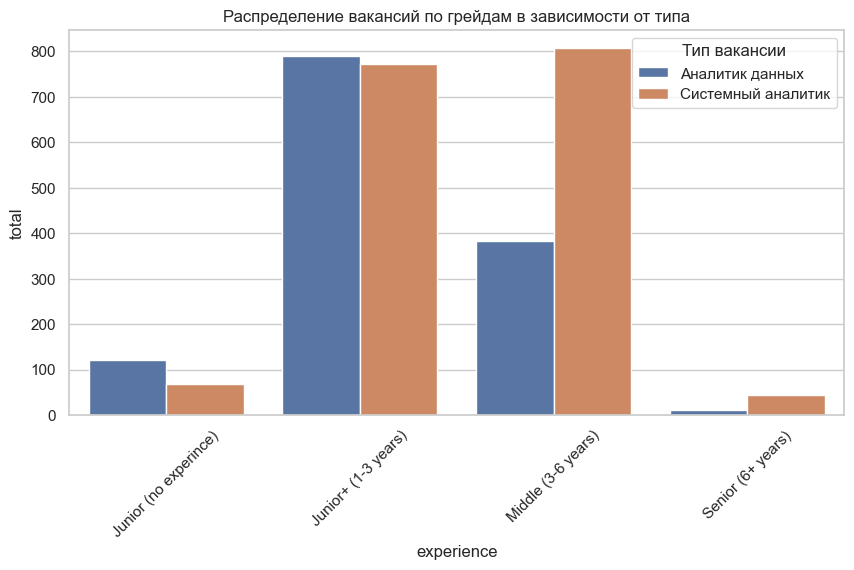

In [65]:
plt.figure(figsize=(10, 5))
sns.barplot(data=exp_source, x='experience', y='total', hue='source')
plt.xticks(rotation=45)
plt.legend(title='Тип вакансии')
plt.title('Распределение вакансий по грейдам в зависимости от типа');

### Доли грейдов Junior, Junior+, Middle, Senior среди вакансий Аналитик данных и Системный аналитик.

In [66]:
exp_source[exp_source['source'] == 'Аналитик данных']['total'].sum()

1302

In [67]:
exp_source[exp_source['source'] == 'Системный аналитик']['total'].sum()

1691

In [68]:
exp_source_sys = exp_source[exp_source['source'] == 'Системный аналитик']
exp_source_sys['part'] = exp_source_sys['total'] * 100 / exp_source_sys['total'].sum()

C:\Users\user\AppData\Local\Temp\ipykernel_12480\3588281212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_source_sys['part'] = exp_source_sys['total'] * 100 / exp_source_sys['total'].sum()


In [69]:
exp_source_sys

,experience,source,total,part
1,Junior (no experince),Системный аналитик,68,4.02
3,Junior+ (1-3 years),Системный аналитик,772,45.65
5,Middle (3-6 years),Системный аналитик,807,47.72
7,Senior (6+ years),Системный аналитик,44,2.60


In [70]:
exp_source_data = exp_source[exp_source['source'] == 'Аналитик данных']
exp_source_data['part'] = exp_source_data['total'] * 100 / exp_source_data['total'].sum()

C:\Users\user\AppData\Local\Temp\ipykernel_12480\692270174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_source_data['part'] = exp_source_data['total'] * 100 / exp_source_data['total'].sum()


In [71]:
exp_source_data

,experience,source,total,part
0,Junior (no experince),Аналитик данных,120,9.22
2,Junior+ (1-3 years),Аналитик данных,789,60.60
4,Middle (3-6 years),Аналитик данных,382,29.34
6,Senior (6+ years),Аналитик данных,11,0.84


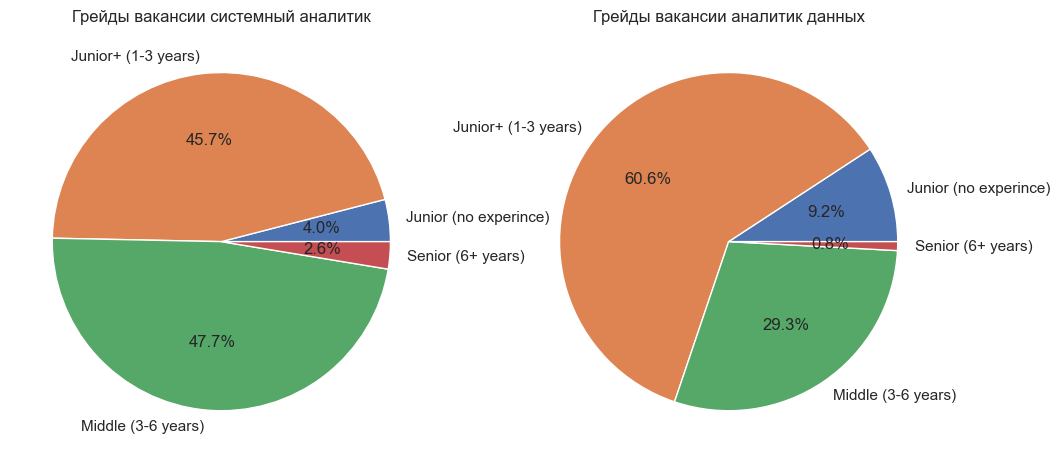

In [72]:
plt.figure(figsize=(12, 8))

ax1 = plt.subplot(1, 2, 1)
plt.pie(x = exp_source_sys['total'], labels = exp_source_sys['experience'], colors = colors, autopct='%.1f%%')
plt.title('Грейды вакансии системный аналитик');

ax2 = plt.subplot(1, 2, 2)
plt.pie(x = exp_source_data['total'], labels = exp_source_data['experience'], colors = colors, autopct='%.1f%%')
plt.title('Грейды вакансии аналитик данных');

plt.show()

Среди системных аналитиков наиболее востребованы специалисты уровня Junior+ с опытом 1-3 года и Middle с опытом от 3 до 6 лет.

Среди аналитиков данных 60% вакансий выставлены на должность Junior+, зато компании чаще готовы нанимать аналитиков без опыта - 9,2% таких вакансий, против 4% среди системных аналитиков.

На данную структуру вакансий может также сказываться тот факт, что специалистов с опытом чаще хантят и находят по внутренним каналам, не всегда выставляя вакансии.

### Портрет работодателя
Определение типичного места работы по следующим параметрам: ТОП-работодателей, зарплата, тип занятости, график работы. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
Цветные гистограммы распределения зарплаты в зависимости от грейда

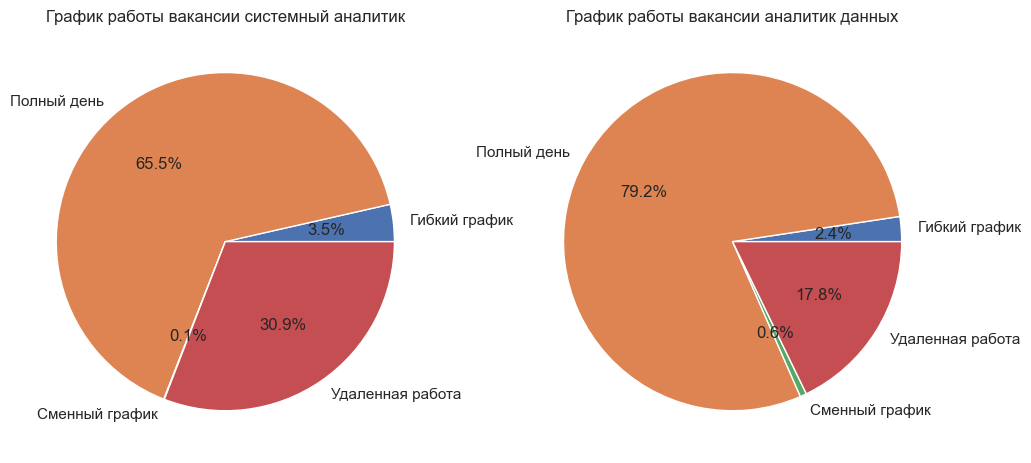

In [73]:
sched_source = df.pivot_table(index=('schedule','source'), values=('name'),aggfunc=('count'))
sched_source = sched_source.rename(columns={'name':'total'})
sched_source.reset_index(inplace=True)
#sched_source
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
plt.pie(x = sched_source[sched_source['source'] == 'Системный аналитик']['total'], labels = sched_source[sched_source['source'] == 'Системный аналитик']['schedule'], colors = colors, autopct='%.1f%%')
plt.title('График работы вакансии системный аналитик');

ax2 = plt.subplot(1, 2, 2)
plt.pie(x = sched_source[sched_source['source'] == 'Аналитик данных']['total'], labels = sched_source[sched_source['source'] == 'Аналитик данных']['schedule'], colors = colors, autopct='%.1f%%')
plt.title('График работы вакансии аналитик данных');

plt.show()

In [74]:
sched_exp = df.pivot_table(index=('source','experience','schedule'), values=('name'),aggfunc=('count'))
sched_exp = sched_exp.rename(columns={'name':'total'})
sched_exp.reset_index(inplace=True)
#sched_exp = sched_exp.sort_values(by='schedule')

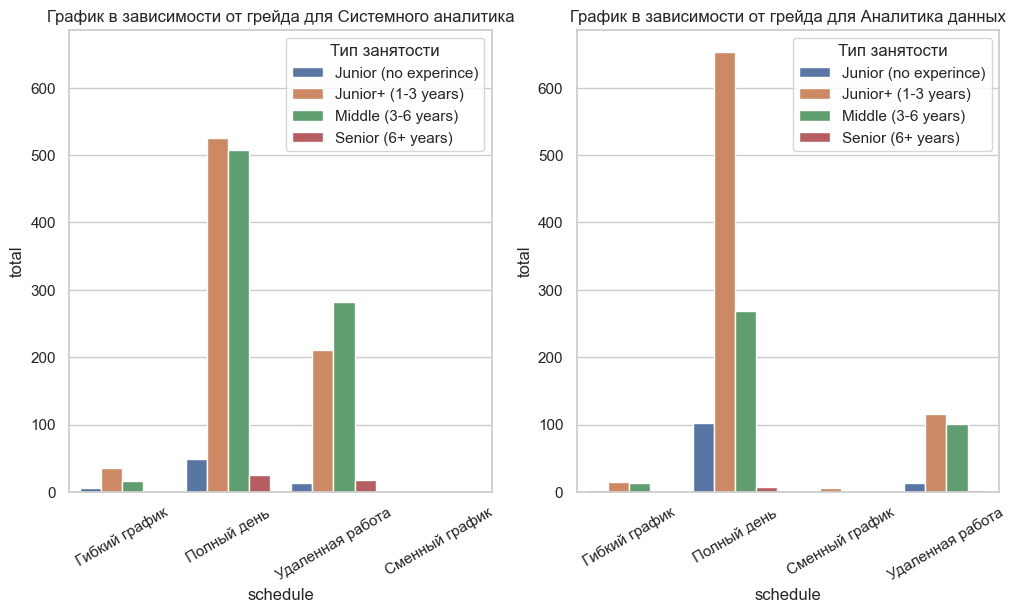

In [75]:

plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=sched_exp[sched_exp['source'] == 'Системный аналитик'], x='schedule', y='total', hue='experience')
plt.xticks(rotation=30)
plt.legend(title='Тип занятости')
plt.title('График в зависимости от грейда для Системного аналитика');

ax2 = plt.subplot(1, 2, 2, sharey = ax1)
sns.barplot(data=sched_exp[sched_exp['source'] == 'Аналитик данных'], x='schedule', y='total', hue='experience')
plt.xticks(rotation=30)
plt.legend(title='Тип занятости')
plt.title('График в зависимости от грейда для Аналитика данных');

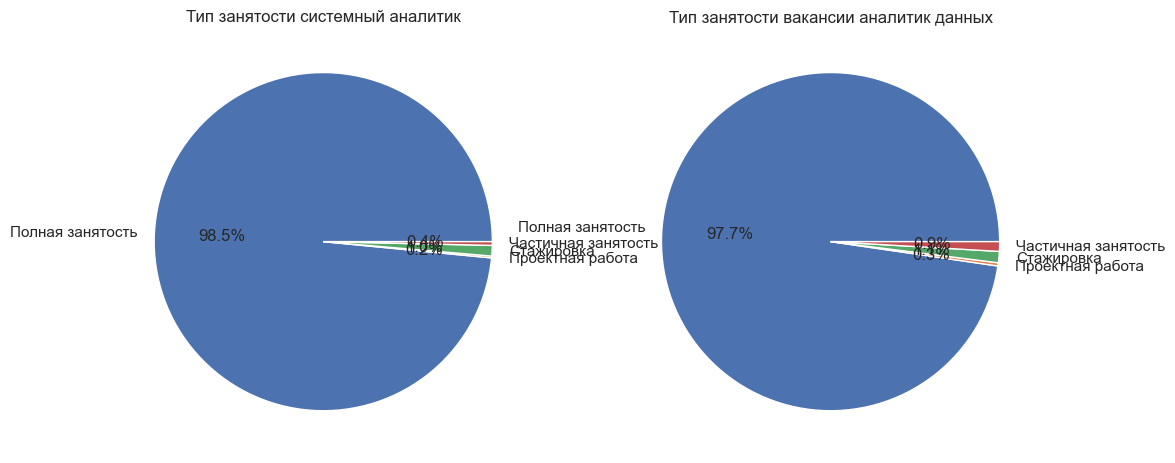

In [76]:
emplmnt_source = df.pivot_table(index=('employment','source'), values=('name'),aggfunc=('count'))
emplmnt_source = emplmnt_source.rename(columns={'name':'total'})
emplmnt_source.reset_index(inplace=True)
#sched_source
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1)
plt.pie(x = emplmnt_source[emplmnt_source['source'] == 'Системный аналитик']['total'], labels = emplmnt_source[emplmnt_source['source'] == 'Системный аналитик']['employment'], colors = colors, autopct='%.1f%%')
plt.title('Тип занятости системный аналитик');

ax2 = plt.subplot(1, 2, 2)
plt.pie(x = emplmnt_source[emplmnt_source['source'] == 'Аналитик данных']['total'], labels = emplmnt_source[emplmnt_source['source'] == 'Аналитик данных']['employment'], colors = colors, autopct='%.1f%%')
plt.title('Тип занятости вакансии аналитик данных');

plt.show()

В 98% случаев компании ищут сотрудника на вакансию с полной занятостью без гибкого графика, в 31% вакансий Системного аналитика и в 18% вакансий Аналитика данных возможен удаленный формат работы.

В основном удаленный формат работы предлагают для соискателей уровня Junior+ и Middle

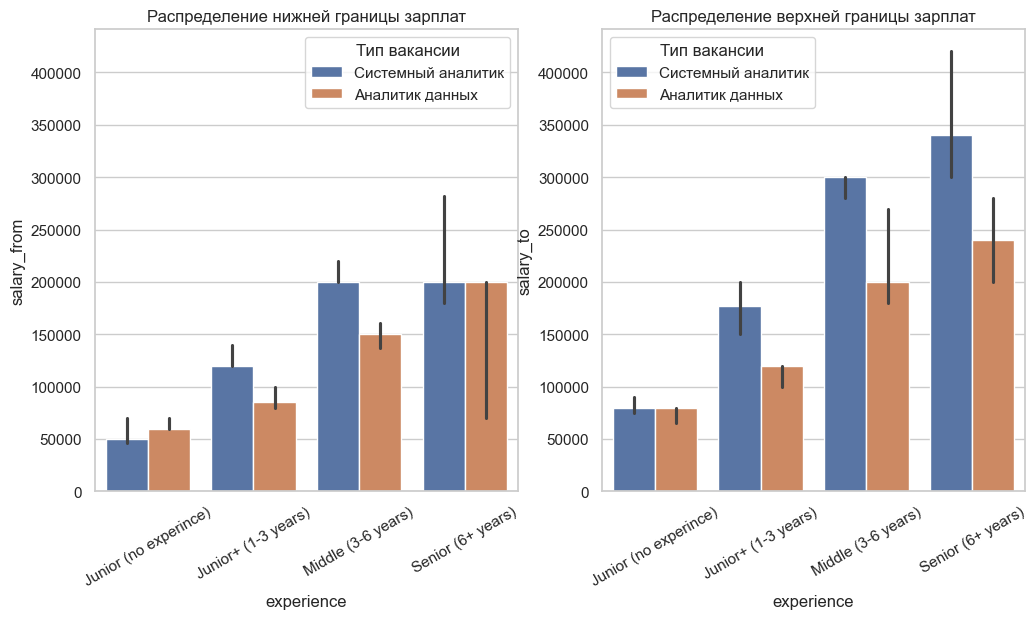

In [77]:
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(1, 2, 1)
sns.barplot(data=df, x='experience', y='salary_from', hue='source', order = exp_source['experience'], estimator=median)
plt.legend(title='Тип вакансии')
plt.xticks(rotation=30)
plt.title('Распределение нижней границы зарплат')
ax2 = plt.subplot(1, 2, 2, sharey = ax1)
sns.barplot(data=df, x='experience', y='salary_to', hue='source', order = exp_source['experience'], estimator=median)
plt.legend(title='Тип вакансии')
plt.xticks(rotation=30)
plt.title('Распределение верхней границы зарплат');

Зарплаты системных аналитиков выше, чем у аналитиков данных, если рассматривать медианные значения верхней и нижней границ вилки зарплат по вакансиям, где они опубликованы. Эта тенденция сохраняется для всех грейдов кроме джунов без опыта.

Системные аналитики без опыта получают в среднем от 50 000 до 75 000 рублей, Аналитики данных от 60 000 до 75 000.
Системные аналитики Джун+ получают от 120 000 до 175 000, а аналитик данных того же грейда от 80 000 до 120 000.
Миддл системные аналитики получают от 200 000 до 300 000, аналитик данных от 150 000 до 200 000.
Выборка по сениорам слишком мала, особенно для аналитиков данных, но системные аналитики получают от 200 000 до 340 000.

In [78]:
top_empl = df.pivot_table(index=('employer'), columns=('source'),values=('name'),aggfunc=('count'))
top_empl.reset_index(inplace=True)
top_empl = top_empl.fillna(0)
top_empl['Всего вакансий'] = top_empl['Аналитик данных'] + top_empl['Системный аналитик']
#top_empl = top_empl.rename(columns={'name':'total_vac'})
top_empl = top_empl.sort_values(by='Всего вакансий', ascending = False).head(25)
#top_empl


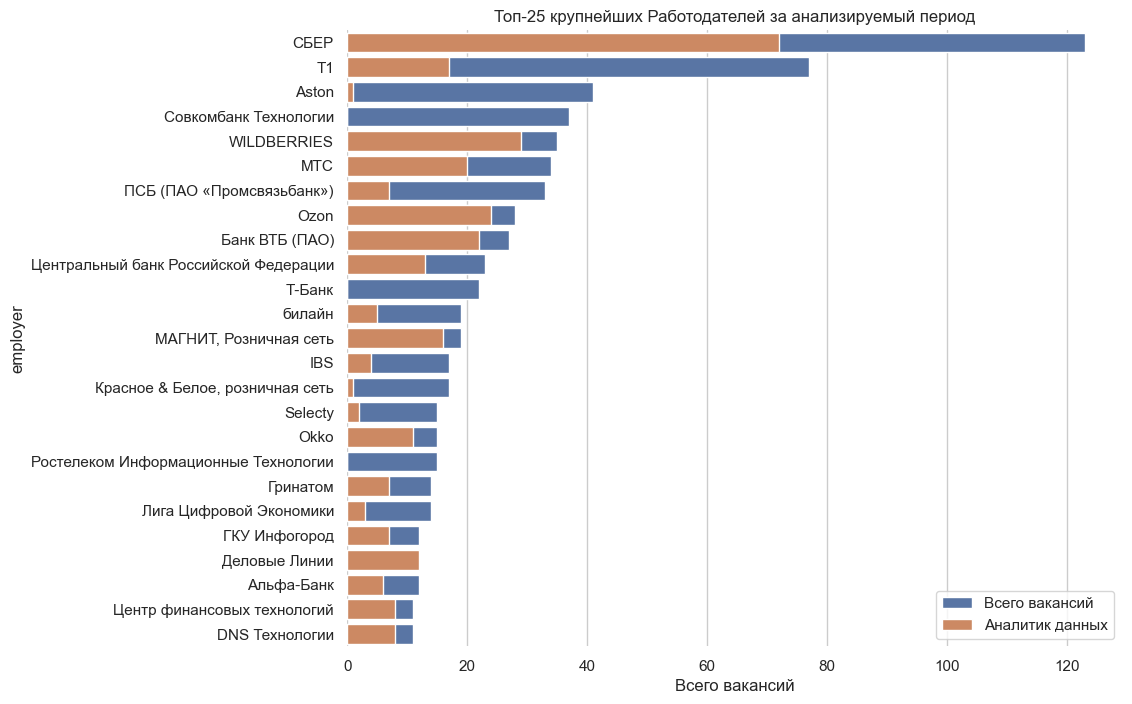

In [79]:

f, ax = plt.subplots(figsize=(10, 8))


sns.barplot(x="Всего вакансий", y="employer", data=top_empl,
            label="Всего вакансий")

sns.barplot(x="Аналитик данных", y="employer", data=top_empl,
            label="Аналитик данных")
plt.title('Топ-25 крупнейших Работодателей за анализируемый период')

sns.despine(left=True, bottom=True)

Крупнейшим работодателем на площадке HH.ru по вакансиям Системный аналитик и Аналитик данных является Сбер, более 120 открытых вакансий в исследуемый период вакансий аналитика данных чуть больше, чем открытых вакансий на системного аналитика.

На втором месте ИТ холдинг Т1, где требуются преимущественно системные аналитики. На третьем месте разработчик ПО Aston, где также требуются преимущественно системные аналитики.

Всего в топ-25 работодателей 8 банков, 4 разработчика ПО, 3 телеком-компании, 2 маркет-плейса, 2 сети розничной торговли,

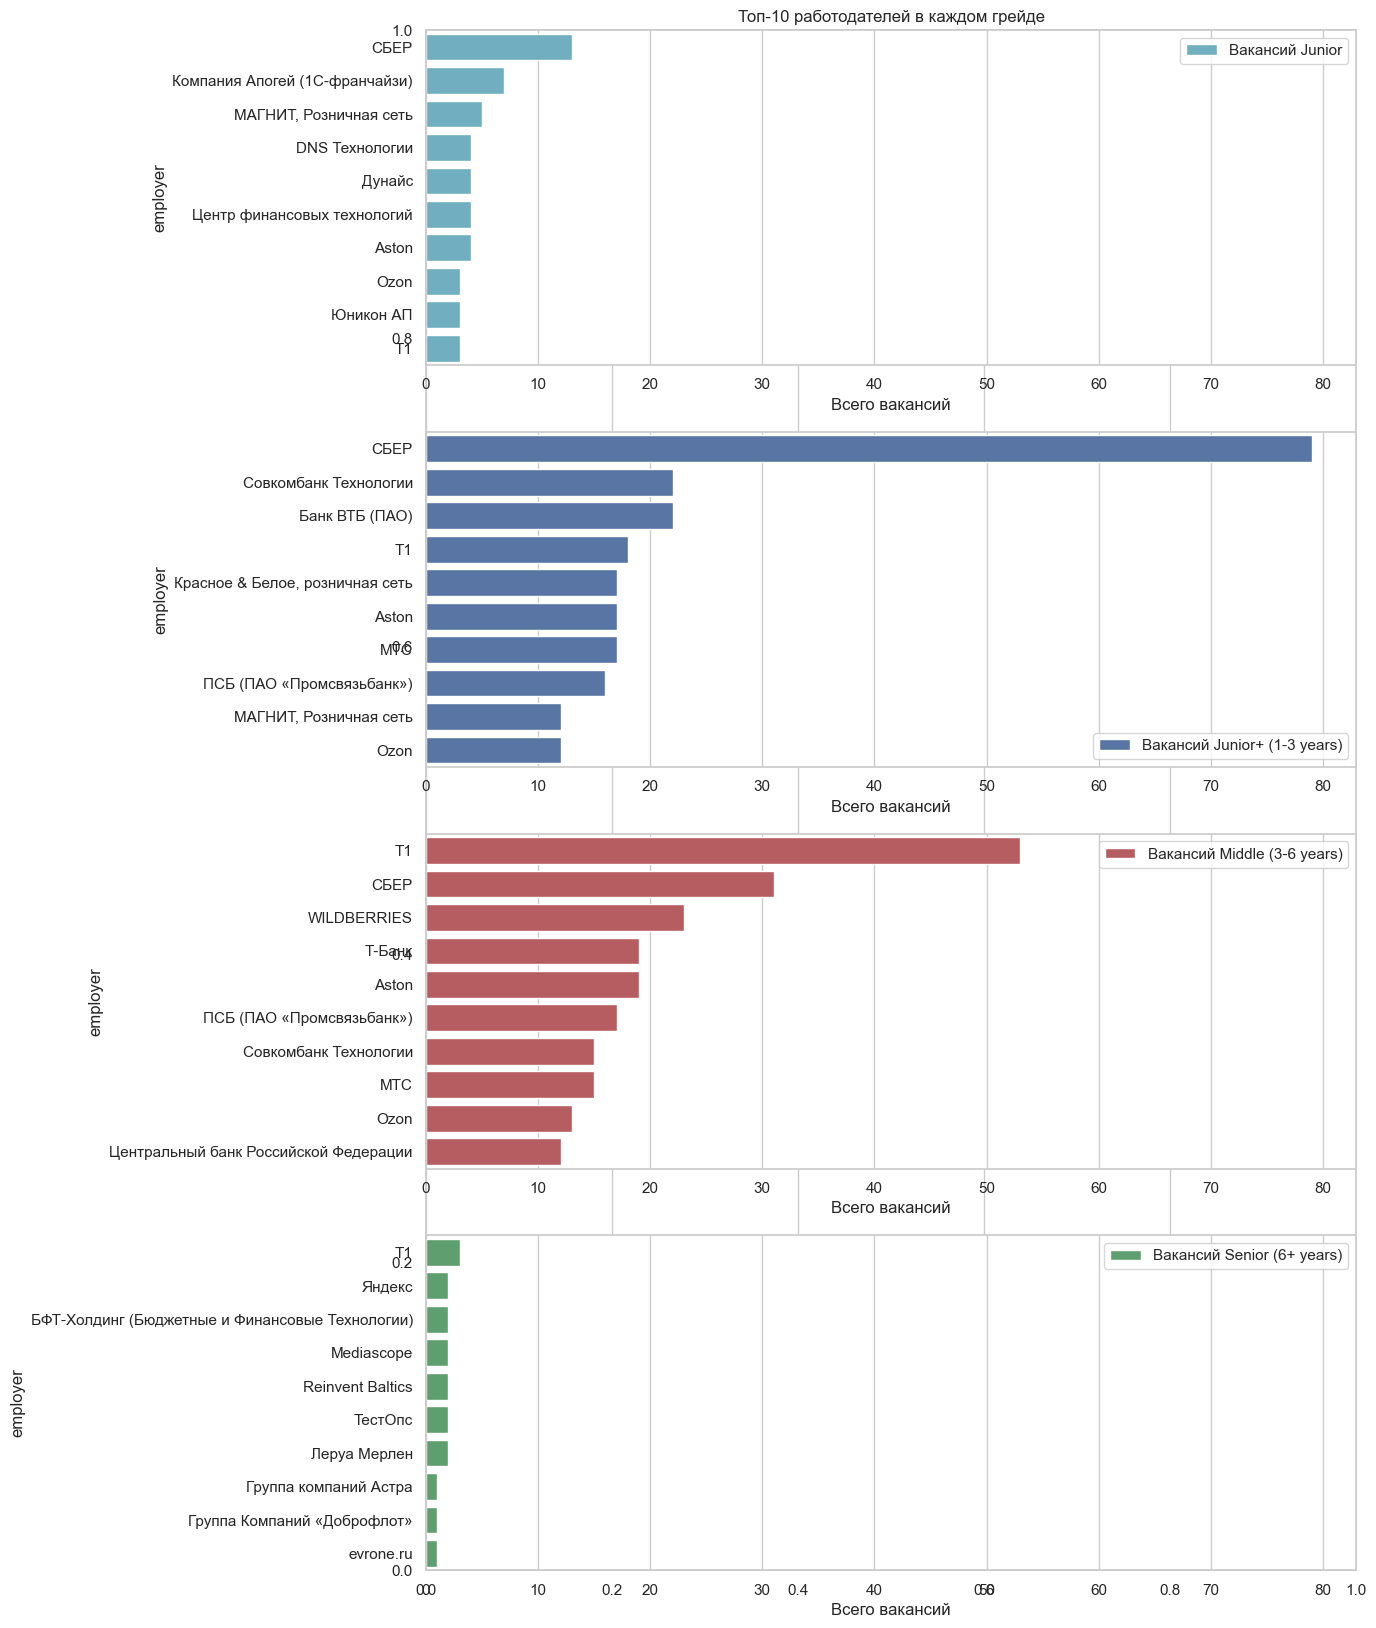

In [80]:
exp_empl = df.pivot_table(index=('experience','employer'),values=('name'),aggfunc=('count'))
exp_empl.reset_index(inplace=True)
exp_empl = exp_empl.fillna(0)
#exp_empl['Всего вакансий'] = exp_empl['Аналитик данных'] + exp_empl['Системный аналитик']
exp_empl = exp_empl.rename(columns={'name':'Всего вакансий'})
exp_empl = exp_empl.sort_values(by='Всего вакансий', ascending = False)

plt.figure(figsize=(12, 20))
plt.title('Топ-10 работодателей в каждом грейде')
ax1 = plt.subplot(4, 1, 1)
sns.barplot(x="Всего вакансий", y="employer", data=exp_empl[exp_empl['experience'] == 'Junior (no experince)'].head(10),
            label="Вакансий Junior", color="c")

ax2 = plt.subplot(4, 1, 2, sharex = ax1)
sns.barplot(x="Всего вакансий", y="employer", data=exp_empl[exp_empl['experience'] == 'Junior+ (1-3 years)'].head(10),
            label="Вакансий Junior+ (1-3 years)", color="b")

ax3 = plt.subplot(4, 1, 3, sharex = ax1)
sns.barplot(x="Всего вакансий", y="employer", data=exp_empl[exp_empl['experience'] == 'Middle (3-6 years)'].head(10),
            label="Вакансий Middle (3-6 years)", color="r")

ax4 = plt.subplot(4, 1, 4, sharex = ax1)
sns.barplot(x="Всего вакансий", y="employer", data=exp_empl[exp_empl['experience'] == 'Senior (6+ years)'].head(10),
            label="Вакансий Senior (6+ years)", color="g");

Аналитиков без опыта чаще всего готовы нанимать в Сбере, Апогей, Магните.
С опытом от 1 до 3 лет особенно нужны в Сбере, Совкомбанке и ВТБ.
Миддл-аналитики нужны разработчику ПО Т1, Сберу, Вайлдберриз, Т-Банку.
Вакансии на грейд Senior опубликованы от Т1, Яндекса, БФТ, Mediascope, Reinvent Baltics ТестОпс, Леруа Мерлен.

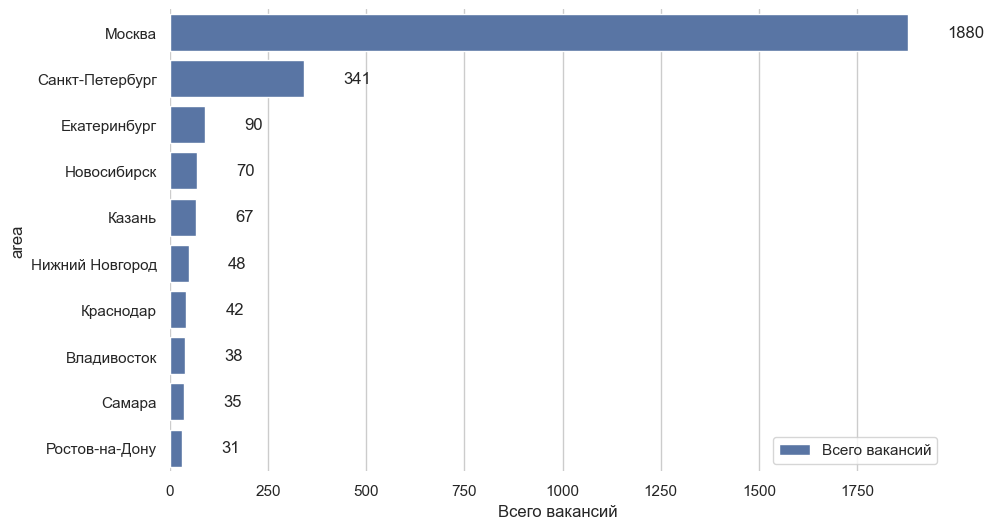

In [81]:
top_area = df.pivot_table(index=('area'), columns=('source'),values=('name'),aggfunc=('count'))
top_area.reset_index(inplace=True)
top_area = top_area.fillna(0)
top_area['Всего вакансий'] = top_area['Аналитик данных'] + top_area['Системный аналитик']
#top_empl = top_empl.rename(columns={'name':'total_vac'})
top_area = top_area.sort_values(by='Всего вакансий', ascending = False).head(10)

f, ax = plt.subplots(figsize=(10, 6))

#sns.set_color_codes("pastel")
sns.barplot(x="Всего вакансий", y="area", data=top_area,
            label="Всего вакансий", color="b")

#sns.set_color_codes("muted")
#sns.barplot(x="Аналитик данных", y="area", data=top_area,
#            label="Аналитик данных", color="b")
#plt.title('Топ-10 городов по количеству вакансий')

for p in ax.patches:
    width = p.get_width()   
    ax.text(width + 100,       
            p.get_y() + p.get_height() / 2, 
            '{:1.0f}'.format(width),
            ha = 'left',
            va = 'center') 

sns.despine(left=True, bottom=True)

60% всех компаний ищут сотрудника в Москве, 10% в Питере, 3% в Екатеринбурге, Больше 2% в Новосибе и Казани.

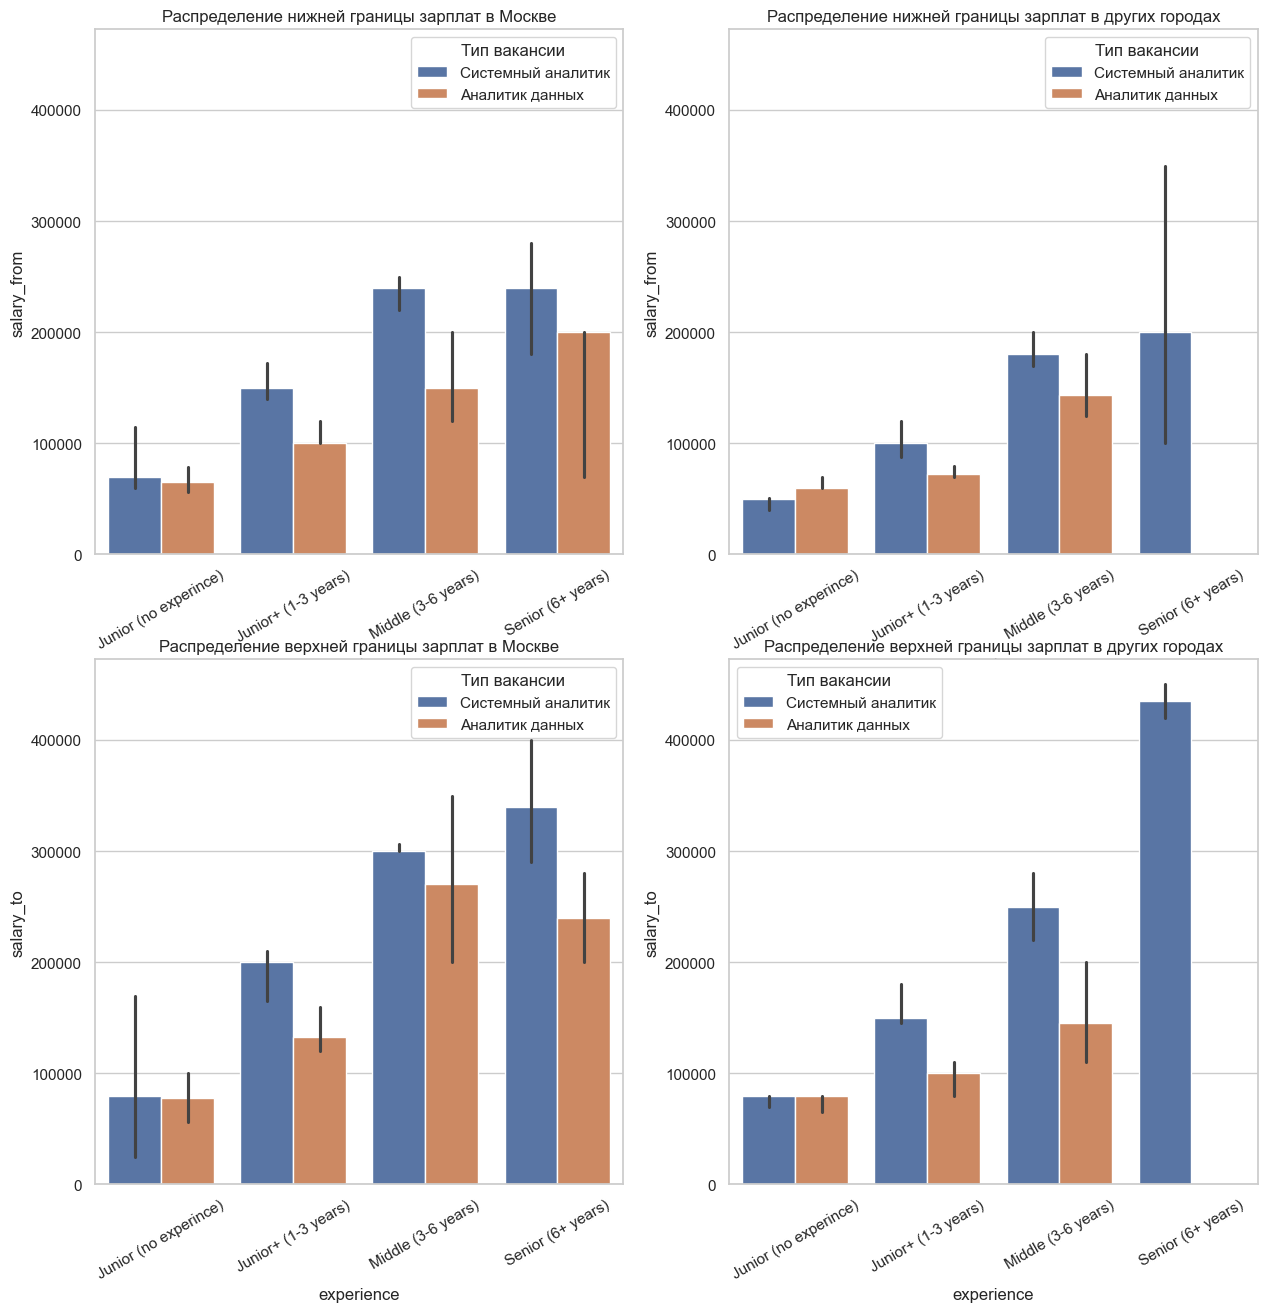

In [82]:
plt.figure(figsize=(15, 15))
ax1 = plt.subplot(2, 2, 1)
sns.barplot(data=df.query('area =="Москва"'), x='experience', y='salary_from', hue='source', order = exp_source['experience'], estimator=median)
plt.legend(title='Тип вакансии')
plt.xticks(rotation=30)
plt.title('Распределение нижней границы зарплат в Москве')
ax2 = plt.subplot(2, 2, 2, sharey = ax1)
sns.barplot(data=df.query('area !="Москва"'), x='experience', y='salary_from', hue='source', order = exp_source['experience'], estimator=median)
plt.legend(title='Тип вакансии')
plt.xticks(rotation=30)
plt.title('Распределение нижней границы зарплат в других городах');

ax3 = plt.subplot(2, 2, 3, sharey = ax1)
sns.barplot(data=df.query('area =="Москва"'), x='experience', y='salary_to', hue='source', order = exp_source['experience'], estimator=median)
plt.legend(title='Тип вакансии')
plt.xticks(rotation=30)
plt.title('Распределение верхней границы зарплат в Москве')
ax4 = plt.subplot(2, 2, 4, sharey = ax1)
sns.barplot(data=df.query('area !="Москва"'), x='experience', y='salary_to', hue='source', order = exp_source['experience'], estimator=median)
plt.legend(title='Тип вакансии')
plt.xticks(rotation=30)
plt.title('Распределение верхней границы зарплат в других городах');

Также Москва готова предложить более высокие зарплаты для соискателей с опытом, верхние и нижние границы зарплат в Москве выше для Junior+ и Middle Системных аналитиков и Аналитиков данных.

### Портрет соискателя
Определение наиболее желаемых кандидатов на вакансии Аналитик данных и Системный аналитик по следующим параметрам: самые важные hard-skils, самые важные soft-skils. Ответ отдельно дайте для грейдов Junior, Junior+, Middle, Senior.
Какие навыки спрашивают чаще - твердые или мягкие. 
К какому грейду и к какой специальности требований больше.

In [83]:
top_skills_raw(df.query('experience == "Junior (no experince)" and source == "Системный аналитик"')['key_skills']).head(20)


,skill,count,popularity
0,Документация,42,73.68
1,Аналитическое мышление,36,63.16
2,SQL,23,40.35
3,Разработка технических заданий,22,38.60
4,Системный анализ,19,33.33
5,Atlassian Confluence,18,31.58
6,UML,13,22.81
7,BPMN,13,22.81
8,Анализ данных,12,21.05
9,Анализ бизнес показателей,11,19.30


In [84]:
top_skills_raw(df.query('experience == "Junior (no experince)" and source == "Системный аналитик"')['key_skills']).tail(1)


,skill,count,popularity
108,Не заполнено,11,19.30


In [85]:
top_skills_raw(df.query('experience == "Junior (no experince)" and source == "Аналитик данных"')['key_skills']).head(20)

,skill,count,popularity
0,Анализ данных,44,47.83
1,Аналитическое мышление,36,39.13
2,SQL,36,39.13
3,Python,28,30.43
4,MS Excel,27,29.35
5,Работа с базами данных,22,23.91
6,Работа с большим объемом информации,17,18.48
7,Pandas,16,17.39
8,Документация,16,17.39
9,Коммуникация,15,16.30


In [86]:
top_skills_raw(df.query('experience == "Junior (no experince)" and source == "Аналитик данных"')['key_skills']).tail(1)

,skill,count,popularity
157,Не заполнено,28,30.43


**Новыки для позиции Junior**

Ключевые навыки для грейда Junior, в целом более общие чем у других грейдов, работодатель выдвигает меньше требований к узкоспецифичным хард скиллам и чаще описывает идеального сосикателя через софт скиллы и общие умения, такие как Анализ ланных, Аналитическое мышление, умение работать с документацией и ставить задачи.

Для Системного Аналитика ключевым навыком является умение работать с документацией (указано в 73% вакансий с заполненными навыками), Аналитическое мышление (63%) и SQL (40%) в 30% вакансий требуется разработка ТЗ, навык системного анализа и знание Atlassian Confluence.

Для Аналитика данных в чаще всего требуется общий навык анализа и аналитическое мышление, затем уже идуть Хард скиллы SQL на 3 месте (39%), Python (30%), Excel (30%), навык работы с большими объемами информации и с базами данными в принципе.

In [87]:
top_skills_raw(df.query('experience == "Junior+ (1-3 years)" and source == "Системный аналитик"')['key_skills']).head(20)


,skill,count,popularity
0,Документация,540,74.69
1,SQL,282,39.00
2,Atlassian Confluence,281,38.87
3,BPMN,253,34.99
4,Разработка технических заданий,223,30.84
5,UML,214,29.60
6,Системный анализ,209,28.91
7,REST API,174,24.07
8,Аналитическое мышление,158,21.85
9,Коммуникация,119,16.46


In [88]:
top_skills_raw(df.query('experience == "Junior+ (1-3 years)" and source == "Системный аналитик"')['key_skills']).tail(1)


,skill,count,popularity
582,Не заполнено,49,6.78


In [89]:
top_skills_raw(df.query('experience == "Junior+ (1-3 years)" and source == "Аналитик данных"')['key_skills']).head(20)

,skill,count,popularity
0,SQL,429,65.50
1,Анализ данных,407,62.14
2,Python,246,37.56
3,Аналитическое мышление,212,32.37
4,Работа с базами данных,159,24.27
5,MS Power BI,155,23.66
6,MS Excel,129,19.69
7,Pandas,124,18.93
8,Документация,111,16.95
9,Работа с большим объемом информации,95,14.50


In [90]:
top_skills_raw(df.query('experience == "Junior+ (1-3 years)" and source == "Аналитик данных"')['key_skills']).tail(1)

,skill,count,popularity
583,Не заполнено,134,20.46


**Навыки для позиции Junior+**

Грейд Junior+ уже предусматривает минимальный опыт работы, поэтому и требования к навыкам более обширны, среди основных требований чаще выделяют хард скилы и знание специфичных программ и языков.

Для системных аналитков по-прежнему ключевым навыком является умение работать с документацией (75% вакансий), на втором и третьем месте SQL и Confluence (40%), далее идёт умение описывать бизнес-процессы (35%), 5-6 место в популярности это навык разработки ТЗ и знание UML (30%).
Чаще требуется знание узкоспециальных инструемнтов: JSON, SOAP, REST.

Для Аналитика Данных Junior+ на первое место вышел хард скилл знание SQL (указан в 65% вакансий), на втором месте общий навык анализа данных (62%), третье место занимает снова специфический навык владение Python, также в топе общий навык работы с БД и 2 хард-скилла: Power BI и Excel.
Начинают фигурировать и более специализированные требования: статистический анализ, анализ бизнес-показателей.

In [91]:
top_skills_raw(df.query('experience == "Middle (3-6 years)" and source == "Системный аналитик"')['key_skills']).head(20)


,skill,count,popularity
0,Документация,589,77.91
1,SQL,336,44.44
2,Atlassian Confluence,325,42.99
3,Системный анализ,282,37.30
4,BPMN,282,37.30
5,UML,253,33.47
6,REST API,219,28.97
7,Разработка технических заданий,168,22.22
8,Коммуникация,124,16.40
9,SOAP API,122,16.14


In [92]:
top_skills_raw(df.query('experience == "Middle (3-6 years)" and source == "Системный аналитик"')['key_skills']).tail(1)


,skill,count,popularity
587,Не заполнено,51,6.75


In [93]:
top_skills_raw(df.query('experience == "Middle (3-6 years)" and source == "Аналитик данных"')['key_skills']).head(20)

,skill,count,popularity
0,SQL,222,68.10
1,Анализ данных,184,56.44
2,Python,169,51.84
3,Pandas,82,25.15
4,Документация,79,24.23
5,MS Power BI,69,21.17
6,Работа с базами данных,66,20.25
7,Аналитическое мышление,62,19.02
8,Коммуникация,47,14.42
9,Статистический анализ,41,12.58


In [94]:
top_skills_raw(df.query('experience == "Middle (3-6 years)" and source == "Аналитик данных"')['key_skills']).tail(1)

,skill,count,popularity
368,Не заполнено,56,17.18


**Навыки для позиции Middle**

В целом, начиная с позиции Junior+ основной стэк навыков меняется не сильно.

В топ навыков для Системного аналитика добавился Системный анализ, но в остальном даже порядок популярности изменился не сильно: Умение вести документацию (75% вакансий), SQL и Confluence (39%), умение описывать бизнес-процессы и ТЗ. Много внимания уделяется специфичным умениям спрашиваются JSON, SOAP, REST.

В топе навыков для Аналитика данных по-прежнему SQL (68%), Python (52%), навык анализа данных и аналитическое мышление. Поднялись среди популярных требований знания Pandas (25%), Power BI (22%), навык коммуникации (14%), чаще спрашивают имение проводить аналитические исследования А/В тестирование, прогнозирование и работу с BigData.

В целом наблюдается тенденция, что чем выше грейд, тем меньше вакансий с незаполненными навыками.

In [95]:
top_skills_raw(df.query('experience == "Senior (6+ years)" and source == "Системный аналитик"')['key_skills']).head(20)


,skill,count,popularity
0,Документация,29,72.50
1,SQL,22,55.00
2,REST API,18,45.00
3,BPMN,17,42.50
4,Atlassian Confluence,17,42.50
5,UML,17,42.50
6,Системный анализ,16,40.00
7,Разработка технических заданий,11,27.50
8,JSON API,11,27.50
9,SOAP API,8,20.00


In [96]:
top_skills_raw(df.query('experience == "Senior (6+ years)" and source == "Системный аналитик"')['key_skills']).tail(1)

,skill,count,popularity
92,Не заполнено,4,10.00


In [97]:
top_skills_raw(df.query('experience == "Senior (6+ years)" and source == "Аналитик данных"')['key_skills']).head(20)

,skill,count,popularity
0,SQL,7,70.00
1,Python,7,70.00
2,Анализ данных,6,60.00
3,Статистический анализ,4,40.00
4,MS Power BI,4,40.00
5,Проактивность,3,30.00
6,Tableau,3,30.00
7,Юнит-экономика,3,30.00
8,Аналитические исследования,3,30.00
9,Английский язык,3,30.00


In [98]:
top_skills_raw(df.query('experience == "Senior (6+ years)" and source == "Аналитик данных"')['key_skills']).tail(1)

,skill,count,popularity
44,Не заполнено,1,10.00


**Навыки для позиции Senior**

Для системного аналитика требования по навыкам на грейде Senior не сильно отличаются от мидловских: вести документацию, SQL, Confluence JSON, SOAP, REST, умение описывать бизнес-процессы и ТЗ, Системный анализ. Выборка по сеньорам меньше чем по другим грейдам, поэтому небольшую перетасовку топа можно объяснить статистическими отклонениями.

Для Аналитика данных всего опубликовано 10 вакансий на сеньиорскую должность, этих данных маловато для достоверного анализа и формирования выводов.

## Выводы

Всего в ходе исследования вакансий с сайта HH.ru было проанализировано 2993 вакансии, опубликованных с февраля по июль 2024 года, из них 1302 на должность аналитика данных и 1691 системного аналитика. В 75% случаев работодатель не стремится раскрывать вилку зарплат сотрудника.

1. Среди системных аналитиков наиболее востребованы специалисты уровня Junior+ с опытом 1-3 года – 45,7% и Middle с опытом от 3 до 6 лет – 47,7%.
2. Среди аналитиков данных 60% вакансий выставлены на должность Junior+, зато компании чаще готовы нанимать аналитиков без опыта - 9,2% таких вакансий, против 4% среди системных аналитиков. Миддл специалисты нужны в 29,3% вакансий аналитика данных.
3. В 98% случаев компании ищут сотрудника на вакансию с полной занятостью без гибкого графика, в 31% вакансий Системного аналитика и в 18% вакансий Аналитика данных возможен удаленный формат работы.
4. В основном удаленный формат работы предлагают для соискателей уровня Junior+ и Middle
Зарплаты системных аналитиков выше, чем у аналитиков данных:
- Системные аналитики без опыта получают в среднем от 50 000 до 75 000 рублей, Аналитики данных от 60 000 до 75 000.- 
Системные аналитики Джун+ получают от 120 000 до 175 000, а аналитик данных того же грейда от 80 000 до 120 000.- 
Миддл системные аналитики получают от 200 000 до 300 000, аналитик данных от 150 000 до 200 000- .
Выборка по сениорам слишком мала, особенно для аналитиков данных, но системные аналитики получают от 200 000 до 340 0
  
5. Крупнейшим работодателем на площадке HH.ru по вакансиям Системный аналитик и Аналитик данных является Сбер, более 120 открытых вакансий в исследуемый период вакансий аналитика данных чуть больше, чем открытых вакансий на системного аналитика.
6. 
На втором месте ИТ холдинг Т1, где требуются преимущественно системные аналитики. На третьем месте разработчик ПО Aston, где также требуются преимущественно системные аналитик.
0.


7. Всего в топ-25 работодателей 8 банков, 4 разработчика ПО, 3 телеком-компании, 2 маркет-плейса, 2 сети розничной торговли
Аналитиков без опыта чаще всего готовы нанимать в Сбере, Апогей, Магните.
С опытом от 1 года особенно нужны в Сбере, Совкомбанке и ВТБ.
Миддл-аналитики нужны разработчику ПО Т1, Сберу, Вайлдберриз, Т-Бан
.
1Вакансии на грейд Senior опубликованы от Т1, Яндекса, БФТ, Mediascope, Reinvent Baltics ТестОпс, Леруа Мерладачи.


8. 60% всех компаний ищут сотрудника в Москве, 10% в Питере, 3% в Екатеринбурге, Больше 2% в Новосибе и Казани.
Также Москва готова предложить более высокие зарплаты для соискателей с опытом, верхние и нижние границы зарплат в Москве выше для Junior+ и Middle Системных аналитиков и Аналитиков данных.
9. Ключевые навыки для грейда Junior, в целом более общие чем у других грейдов, работодатель выдвигает меньше требований к узкоспецифичным хард скиллам и чаще описывает идеального соискателя через софт скиллы и общие умения, такие как Анализ данных, Аналитическое мышление, умение работать с документацией и ставить задачи.
    
Для Системного Аналитика ключевым навыком является умение работать с документацией (указано в 73% вакансий с заполненными навыками), Аналитическое мышление (63%) и SQL (40%) в 30% вакансий требуется разработка ТЗ, навык системного анализа и знание Atlassian Confluence.

Для Аналитика данных в чаще всего требуется общий навык анализа и аналитическое мышление, затем уже идуть Хард скиллы SQL на 3 месте (39%), Python (30%), Excel (30%), навык работы с большими объемами информации и с базами данными в принципе.



10. Грейд Junior+ уже предусматривает минимальный опыт работы, поэтому и требования к навыкам более обширны, среди основных требований чаще выделяют хард скилы и знание специфичных программ и языков.

Для системных аналитков по-прежнему ключевым навыком является умение работать с документацией (75% вакансий), на втором и третьем месте SQL и Confluence (40%), далее идёт умение описывать бизнес-процессы (35%), 5-6 место в популярности это навык разработки ТЗ и знание UML (30%).
Чаще требуется знание узкоспециальных инструемнтов: JSON, SOAP, REST.

Для Аналитика Данных Junior+ на первое место вышел хард скилл знание SQL (указан в 65% вакансий), на втором месте общий навык анализа данных (62%), третье место занимает снова специфический навык владение Python, также в топе общий навык работы с БД и 2 хард-скилла: Power BI и Excel.
Начинают фигурировать и более специализированные требования: статистический анализ, анализ бизнес-показателей.


11. В целом, начиная с позиции Junior+ основной стэк навыков меняется не сильно.

В топ навыков для Мидл Системного аналитика добавился Системный анализ, но в остальном даже порядок популярности изменился не сильно: Умение вести документацию (75% вакансий), SQL и Confluence (39%), умение описывать бизнес-процессы и ТЗ. Много внимания уделяется специфичным умениям спрашиваются JSON, SOAP, REST.

В топе навыков для Мидл Аналитика данных по-прежнему SQL (68%), Python (52%), навык анализа данных и аналитическое мышление. Поднялись среди популярных требований знания Pandas (25%), Power BI (22%), навык коммуникации (14%), чаще спрашивают имение проводить аналитические исследования А/В тестирование, прогнозирование и работу с BigData.

В целом наблюдается тенденция, что чем выше грейд, тем меньше вакансий с незаполненными навыками.


12. Для системного аналитика требования по навыкам на грейде Senior не сильно отличаются от мидловских: вести документацию, SQL, Confluence JSON, SOAP, REST, умение описывать бизнес-процессы и ТЗ, Системный анализ. Выборка по сеньорам меньше, чем по другим грейдам, поэтому небольшую перетасовку топа можно объяснить статистическими отклонениями.